<a href="https://colab.research.google.com/github/psbruno/fairness/blob/main/Testes_aplicando_Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
ad = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz")
diag = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/DIAGNOSES_ICD.csv.gz")
d_diag = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/D_ICD_DIAGNOSES.csv.gz")
d_le = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/D_LABITEMS.csv.gz")
le = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/LABEVENTS.csv.gz")
pat = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/PATIENTS.csv.gz")
proc = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/PROCEDURES_ICD.csv.gz")

In [11]:
ad = pd.read_csv("/content/physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz")
ad.loc[ad['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA','DIAGNOSIS'] = 'CORONARY ARTERY DISEASE'
ad.loc[ad['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA','DIAGNOSIS'] = 'CORONARY ARTERY DISEASE'
ad.loc[ad['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE\CATH','DIAGNOSIS'] = 'CORONARY ARTERY DISEASE'

In [26]:
import itertools
examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

examsList = [str(i) for i in examsList]
def makeDF(examsSubset,data):
  if data.shape[0] == 0:
    return
  examsSubset['SUBJECT_ID'].append(data.loc[0,'SUBJECT_ID'])
  examsSubset['HADM_ID'].append(data.loc[0,'HADM_ID'])
  for i in examsList:
    i = int(i)
    if i in list(data['ITEMID']):
       examsSubset[str(i)].append(sum(list(data[data['ITEMID']==i]['VALUENUM']))/len(list(data[data['ITEMID']==i]['VALUENUM'])))
    else:
      examsSubset[str(i)].append(None)
def buildTests(columns):

  patientsHADM = list(ad[ad['DIAGNOSIS'].isin(columns)].reset_index()['HADM_ID'].drop_duplicates())
  ad[ad['HADM_ID'].isin(patientsHADM)].groupby("DIAGNOSIS").sum()
  examsSubset = {str(i):[] for i in list(examsList)}
  examsSubset['SUBJECT_ID'] = []
  examsSubset['HADM_ID'] = []
  patientsTarget = le[le['HADM_ID'].isin(patientsHADM)]
  patientsTarget = patientsTarget.reset_index().drop(columns='index')
  counter = 0
  for i in patientsHADM:
    makeDF(examsSubset,patientsTarget[patientsTarget['HADM_ID']==i].reset_index())
    counter+=1
    if counter % 500 == 0:
      print(counter)
  df = pd.DataFrame(examsSubset)
  for i in examsList:
    if i in list(df.columns):
      df[i] = df[i].fillna(df[i].mean())
      df[i] = (df[i] - df[i].mean())/df[i].std()
  return df
dfs = []
count = 0
combList = []
for testDisease in ['DIABETIC KETOACIDOSIS']:
  result = buildTests(['CORONARY ARTERY DISEASE','CONGESTIVE HEART FAILURE',testDisease])
  result = result.dropna()
  dfs.append([pd.merge(result, ad, on='HADM_ID', how='inner')])
  count +=1
  print("\n\n\n\n\n")
  print(count)
  print("\n\n\n\n\n")

for i in range(len(dfs)):
  dfs[i][0]['Reduced_ETHNICITY'] = dfs[i][0]['ETHNICITY']
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC OR LATINO','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='BLACK/AFRICAN AMERICAN','Reduced_ETHNICITY'] = 'BLACK'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='UNKNOWN/NOT SPECIFIED','Reduced_ETHNICITY']= 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - CHINESE','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='WHITE - EASTERN EUROPEAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='PATIENT DECLINED TO ANSWER','Reduced_ETHNICITY'] = 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='BLACK/AFRICAN','Reduced_ETHNICITY'] = 'BLACK'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - CAMBODIAN','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='BLACK/HAITIAN','Reduced_ETHNICITY'] = 'BLACK'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='WHITE - RUSSIAN','Reduced_ETHNICITY'] = 'WHITE'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='UNABLE TO OBTAIN','Reduced_ETHNICITY'] = 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='WHITE - BRAZILIAN','Reduced_ETHNICITY'] = 'WHITE'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='BLACK/CAPE VERDEAN','Reduced_ETHNICITY'] = 'BLACK'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - VIETNAMESE','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='MULTI RACE ETHNICITY','Reduced_ETHNICITY'] = 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='WHITE - OTHER EUROPEAN','Reduced_ETHNICITY'] = 'WHITE'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - ASIAN INDIAN','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - MEXICAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - CUBAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - KOREAN','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - GUATEMALAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - PUERTO RICAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - SALVADORAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - DOMINICAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='SOUTH AMERICAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='CARIBBEAN ISLAND','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - FILIPINO','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - COLOMBIAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - JAPANESE - COLOMBIAN','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - THAI','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='HISPANIC/LATINO - HONDURAN','Reduced_ETHNICITY'] = 'LATINO'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - OTHER','Reduced_ETHNICITY'] = 'ASIAN'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','Reduced_ETHNICITY'] = 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='AMERICAN INDIAN/ALASKA NATIVE','Reduced_ETHNICITY'] = 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='PORTUGUESE','Reduced_ETHNICITY'] = 'OTHER'
  dfs[i][0].loc[dfs[i][0]['ETHNICITY']=='ASIAN - JAPANESE','Reduced_ETHNICITY'] = 'ASIAN'


  dfs[i][0].loc[dfs[i][0]['MARITAL_STATUS']=='LIFE PARTNER','MARITAL_STATUS'] = 'UNKNOWN (DEFAULT)'
  dfs[i][0].loc[dfs[i][0]['MARITAL_STATUS'].isna(),'MARITAL_STATUS'] = 'UNKNOWN (DEFAULT)'
  dfs[i][0].loc[dfs[i][0]['MARITAL_STATUS']== 'UNKNOWN (DEFAULT)','MARITAL_STATUS'] = 'UNKNOWN'



  #'AMERICAN INDIAN/ALASKA NATIVE'
  #'PORTUGUESE',
  #'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
  #'MIDDLE EASTERN'
  #'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'
def getYear(series):
  return pd.to_datetime(series).dt.year

for i in range(len(dfs)):
  dfs[i][0] = dfs[i][0].rename(columns={'SUBJECT_ID_x':'SUBJECT_ID'})
  dfs[i][0]['AGE'] = getYear(dfs[i][0].merge(pat[['SUBJECT_ID','GENDER','DOB']],on='SUBJECT_ID')['ADMITTIME']) - getYear(dfs[i][0].merge(pat[['SUBJECT_ID','GENDER','DOB']],on='SUBJECT_ID')['DOB'])
  dfs[i][0] = dfs[i][0].merge(pat[['SUBJECT_ID','GENDER']],on='SUBJECT_ID')
for i in range(len(dfs)):
  dfs[i][0]['Faixa etária'] = 0
  dfs[i][0].loc[dfs[i][0]['AGE'] < 5,'Faixa etária'] = 1 #Bebes
  dfs[i][0].loc[((dfs[i][0]['AGE'] > 5) & (dfs[i][0]['AGE'] < 15) ),'Faixa etária'] = 2 #Crianças
  dfs[i][0].loc[((dfs[i][0]['AGE'] > 14) & (dfs[i][0]['AGE'] < 25) ),'Faixa etária'] = 3 #Adultos
  dfs[i][0].loc[((dfs[i][0]['AGE'] > 25) & (dfs[i][0]['AGE'] < 66) ),'Faixa etária'] = 4 #Adultos
  dfs[i][0].loc[dfs[i][0]['AGE'] > 66,'Faixa etária'] = 5 #Idosos
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','AGE']
for i in range(len(dfs)):
  for j in Subset:
    dfs[i][0]['Coded '+ str(j)] = label_encoder.fit_transform(dfs[i][0][j])

500
1000
1500
2000
2500
3000






1








In [27]:
df = dfs[0][0]
df['CONGESTIVE HEART FAILURE'] = pd.get_dummies(df['DIAGNOSIS'])['CONGESTIVE HEART FAILURE']
df['CORONARY ARTERY DISEASE'] = pd.get_dummies(df['DIAGNOSIS'])['CORONARY ARTERY DISEASE']
df['DIABETIC KETOACIDOSIS'] = pd.get_dummies(df['DIAGNOSIS'])['DIABETIC KETOACIDOSIS']
df


,50912,50802,50931,50971,50960,51221,50868,51006,51250,51222,...,AGE,GENDER,Faixa etária,Coded GENDER,Coded Reduced_ETHNICITY,Coded MARITAL_STATUS,Coded AGE,CONGESTIVE HEART FAILURE,CORONARY ARTERY DISEASE,DIABETIC KETOACIDOSIS
0,-0.515011,-2.109932e-01,-0.335028,-0.956321,-0.415902,-1.267249,-0.898002,-0.540395,0.005088,-0.899363,...,71,M,5,1,4,1,55,False,True,False
1,-0.293598,-1.289350e-01,-0.365367,0.049241,-0.415902,0.060096,-0.318366,-0.447011,0.187060,0.275603,...,74,M,5,1,4,1,58,False,True,False
2,-0.274674,-4.359450e-02,-0.920991,0.000897,1.162108,0.413223,-1.245784,-0.589310,-1.187841,0.882284,...,70,M,5,1,4,1,54,False,True,False
3,-0.354912,1.471199e+00,1.064175,-0.724268,0.175852,-0.274757,-1.315340,0.118631,-0.571157,-0.254284,...,69,M,5,1,4,1,53,True,False,False
4,-0.611525,1.184337e-17,-0.562566,0.798579,-0.077757,1.175223,-0.318366,-0.749398,2.079570,0.759412,...,61,M,4,1,3,1,45,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,-0.361725,3.404377e-01,0.465904,0.145930,-0.711779,-0.844671,-0.898002,-0.393648,0.096074,-0.565304,...,67,M,5,1,4,1,51,False,True,False
3466,-0.491167,-9.337645e-02,-0.859881,-0.917645,-0.120025,-0.024438,-0.984947,-0.905927,-0.249673,0.372365,...,51,M,4,1,4,1,35,False,True,False
3467,0.052716,6.308112e-02,0.782939,1.969202,1.260733,-1.069588,-0.125154,0.611343,-0.702582,-0.650547,...,72,M,5,1,4,1,56,False,True,False
3468,-0.276566,-1.289350e-01,-1.132926,-0.086123,-0.284401,-0.276199,-1.129856,-0.567076,-0.267870,0.085535,...,82,M,5,1,2,3,66,False,True,False


In [28]:
pip install fairlearn

#Grafico de distribuição dos individuos

In [46]:
reffDf = {'Attr':[],
          'source':[],
          'Coded':[]}
protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','INSURANCE']

for i in protectedAttrs:
  temp = df[[i,'Coded '+ i ]].drop_duplicates().reset_index().drop(columns='index')
  for j in range(temp.shape[0]):
    reffDf['Attr'].append('Coded ' + i)
    reffDf['source'].append(temp.loc[j,i])
    reffDf['Coded'].append(temp.loc[j,'Coded '+i])
reffDf = pd.DataFrame(reffDf)

In [30]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score


def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Doenca atual: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  # cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  # newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  # noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(X_resampled, y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Doenca atual: Coded GENDER

Acurácia: 0.92

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.88      0.92      0.90       272
        True       0.95      0.92      0.94       422

    accuracy                           0.92       694
   macro avg       0.92      0.92      0.92       694
weighted avg       0.92      0.92      0.92       694



# Doenca atual: Coded Reduced_ETHNICITY

Acurácia: 0.90

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.86      0.90      0.88       272
        True       0.93      0.91      0.92       422

    accuracy                           0.90       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.91      0.90      0.91       694



# Doenca atual: Coded MARITAL_STATUS

Acurácia: 0.91

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.87      0.90      0.89       272
        True       0.94      0.91      0.93       422

    accuracy                           0.91       694
   macro avg       0.90      0.91      0.91       694
weighted avg       0.91      0.91      0.91       694



,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.929936,0.930905,0.929936,0.930300,0.943114,0.102190
1,F,0.905830,0.906212,0.905830,0.905069,0.840909,0.051852
2,OTHER,0.894309,0.914438,0.894309,0.900689,0.903846,0.157895
3,WHITE,0.902004,0.901668,0.902004,0.901760,0.928826,0.142857
4,BLACK,0.900000,0.910390,0.900000,0.874168,0.272727,0.000000
5,LATINO,0.962963,0.965812,0.962963,0.963065,0.933333,0.000000
6,ASIAN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,MARRIED,0.911846,0.913458,0.911846,0.912514,0.934783,0.160920
8,SINGLE,0.919753,0.920169,0.919753,0.919008,0.852459,0.039604
9,WIDOWED,0.882353,0.885249,0.882353,0.882443,0.916667,0.148148


In [31]:
dist = {'Insuficiência cardíaca':[1824],
        'Cetoacidose diabética':[2406],
        'Doença arterial \ncoronariana':[1305]}

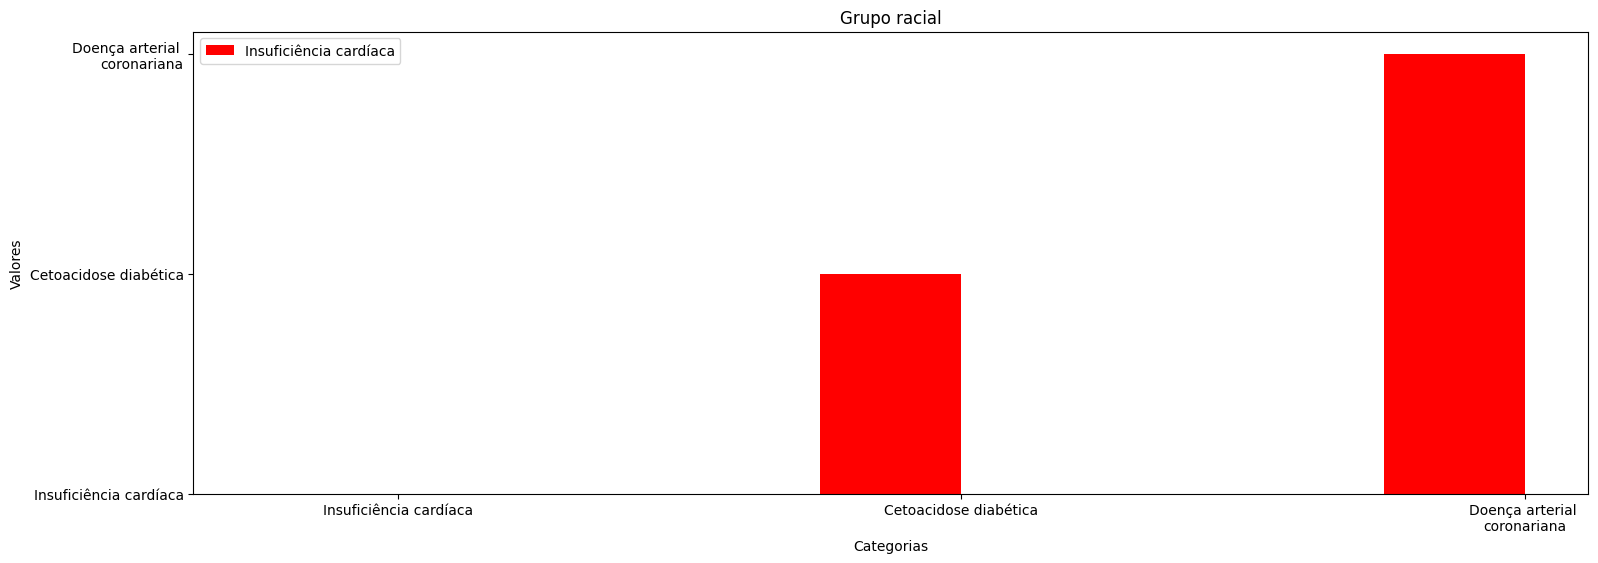

In [32]:
import matplotlib.pyplot as plt

def getGraphic(data):
  valores1 = data['Doenca']
  valores2 = data['Ocorrencias']
  # valores3 = data['Doença arterial \ncoronariana']
  cores = ['red', 'blue', 'green']
  largura_barra = 0.25
  posicoes1 = np.arange(3)
  posicoes2 = posicoes1 + largura_barra
  plt.figure(figsize=(18, 6))
  plt.bar(posicoes1, valores1, largura_barra, color=cores[0], label='Insuficiência cardíaca')
  # plt.bar(posicoes2, valores2, largura_barra, color=cores[1], label='Cetoacidose diabética')
  # plt.bar(posicoes2+largura_barra, valores3, largura_barra, color=cores[2], label='Doença arterial \ncoronariana')
  plt.xlabel('Categorias')
  plt.ylabel('Valores')
  plt.title('Grupo racial')
  plt.xticks(posicoes1 + largura_barra / 2, ['Insuficiência cardíaca','Cetoacidose diabética','Doença arterial \ncoronariana'])
  plt.legend()
  plt.show()
dist = {'Doenca': ['Insuficiência cardíaca','Cetoacidose diabética','Doença arterial \ncoronariana'],
        'Ocorrencias': [1824,2406,1305]}
getGraphic(pd.DataFrame(dist))

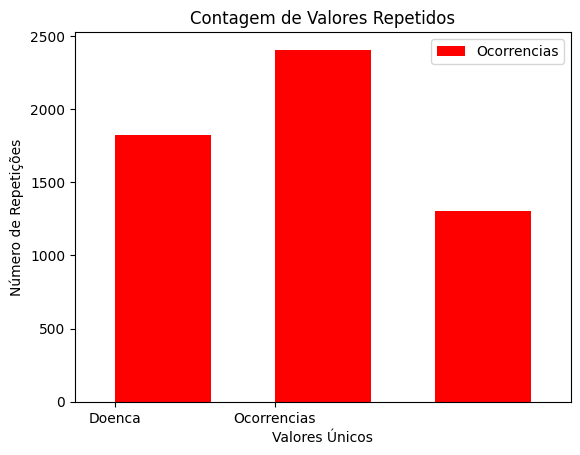

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Dados
dist = {'Doenca': ['Insuficiência cardíaca','Cetoacidose diabética','Doença arterial \ncoronariana'],
        'Ocorrencias': [1824,2406,1305]}
dist = pd.DataFrame(dist)

# Criar uma figura e eixos
fig, ax = plt.subplots()

# Adicionar espaçamento entre as barras e posicionar rótulos abaixo
dist.plot(kind='bar', color=['red', 'blue', 'green'], width=0.6, position=0, ax=ax)

# Adicionar título e rótulos aos eixos
plt.title('Contagem de Valores Repetidos')
plt.xlabel('Valores Únicos')
plt.ylabel('Número de Repetições')

# Definir posições e rótulos no eixo x
posicoes_rotulos = range(len(dist.columns))
ax.set_xticks(posicoes_rotulos)
ax.set_xticklabels(dist.columns, rotation=0, ha='center')  # Altere o valor de rotação conforme necessário

# Exibir o gráfico
plt.show()

<ipython-input-34-8ad5de21f31d>:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d1 = int(groupedData[groupedData['DIAGNOSIS'] == 'CONGESTIVE HEART FAILURE'][turn].fillna(0))
<ipython-input-34-8ad5de21f31d>:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d2 = int(groupedData[groupedData['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE'][turn].fillna(0))
<ipython-input-34-8ad5de21f31d>:57: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d3 = int(groupedData[groupedData['DIAGNOSIS'] == 'DIABETIC KETOACIDOSIS'][turn].fillna(0))
<ipython-input-34-8ad5de21f31d>:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d1 = int(group

<Figure size 1000x800 with 0 Axes>

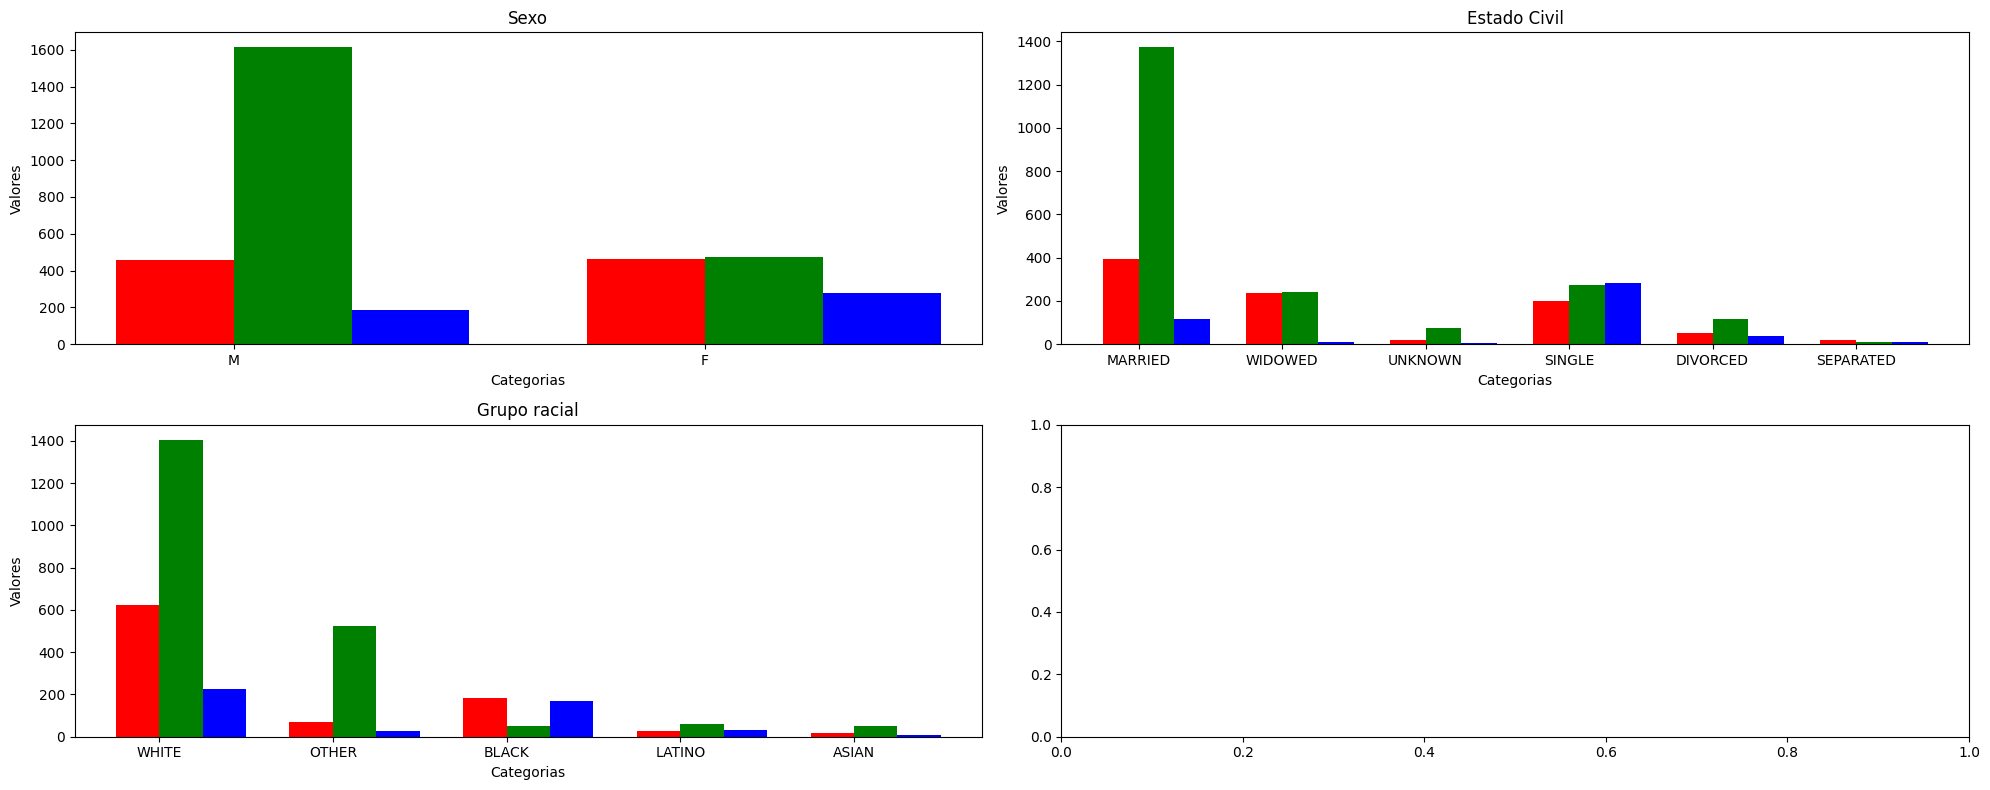

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

dist = {'Insuficiência\n cardíaca': [1824],
        'Cetoacidose\n diabética': [2406],
        'Doença arterial \ncoronariana': [1305]}
cores = ['red', 'blue', 'green']
classes = list(dist.keys())
alturas = [valor[0] for valor in dist.values()]

fig, axs = plt.subplots(2, 2, figsize=(20, 8))
# barras = axs[0,0].bar(classes, alturas, color=cores)
# axs[0,0].set_xlabel('Diagnóstico')
# axs[0,0].set_ylabel('Ocorrências')
# axs[0,0].set_title('Diagósticos\napós reamostragem')
# for barra in barras:
#     altura = barra.get_height()
#     axs[0,0].annotate('{}'.format(altura),
#                 xy=(barra.get_x() + barra.get_width() / 2, altura),
#                 xytext=(0, 3),  # 3 pontos de compensação para cima
#                 textcoords="offset points",
#                 ha='center', va='bottom')


def getGraphic(data,x,y,label):
  categorias = data['Classe']
  valores1 = data['CONGESTIVE HEART FAILURE']
  valores2 = data['CORONARY ARTERY DISEASE']
  valores3 = data['DIABETIC KETOACIDOSIS']
  cores = ['red', 'green', 'blue']
  largura_barra = 0.25
  posicoes1 = np.arange(len(categorias))
  posicoes2 = posicoes1 + largura_barra
  # plt.figure(figsize=(18, 6))
  axs[x,y].bar(posicoes1, valores1, largura_barra, color=cores[0], label='Insuficiência cardíaca')
  axs[x,y].bar(posicoes2, valores2, largura_barra, color=cores[1], label='Doença arterial coronariana')
  axs[x,y].bar(posicoes2+largura_barra, valores3, largura_barra, color=cores[2], label='Cetoacidose diabética')
  axs[x,y].set_xlabel('Categorias')
  axs[x,y].set_ylabel('Valores')
  axs[x,y].set_title(label)
  axs[x,y].set_xticks(posicoes1 + largura_barra / 2, categorias)
  # plt.legend()
  # plt.show()
def getData(data,key,turn,finalData):
  data = data[data[turn] == key]
  groupedData = data.groupby('DIAGNOSIS').count()[turn].reset_index()
  try:
    d1 = int(groupedData[groupedData['DIAGNOSIS'] == 'CONGESTIVE HEART FAILURE'][turn].fillna(0))
  except:
    d1=0
  try:
    d2 = int(groupedData[groupedData['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE'][turn].fillna(0))
  except:
    d2=0

  try:
    d3 = int(groupedData[groupedData['DIAGNOSIS'] == 'DIABETIC KETOACIDOSIS'][turn].fillna(0))
  except:
    d3=0

  finalData['Grupo'].append(turn)
  finalData['Classe'].append(key)
  finalData['CONGESTIVE HEART FAILURE'].append(d1)
  finalData['CORONARY ARTERY DISEASE'].append(d2)
  finalData['DIABETIC KETOACIDOSIS'].append(d3)
  return finalData
def getPlotData():
  return {
             'Grupo':[],
             'Classe':[],
             'CONGESTIVE HEART FAILURE':[],
             'CORONARY ARTERY DISEASE':[],
             'DIABETIC KETOACIDOSIS':[]
            }
plotData = getPlotData()
# 'GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS'
for i in range(len(dfs)):
  for key in dfs[i][0]['GENDER'].unique():
    if type(key) != float :
      plotData = getData(dfs[i][0],str(key),'GENDER',plotData)
pd.DataFrame(plotData)
getGraphic(pd.DataFrame(plotData),0,0,'Sexo')


plotData = getPlotData()
# 'GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS'
for i in range(len(dfs)):
  for key in dfs[i][0]['MARITAL_STATUS'].unique():
    if type(key) != float :
      plotData = getData(dfs[i][0],str(key),'MARITAL_STATUS',plotData)
pd.DataFrame(plotData)
getGraphic(pd.DataFrame(plotData),0,1,'Estado Civil')

plotData = getPlotData()
# 'GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS'
for i in range(len(dfs)):
  for key in dfs[i][0]['Reduced_ETHNICITY'].unique():
    if type(key) != float :
      plotData = getData(dfs[i][0],str(key),'Reduced_ETHNICITY',plotData)
pd.DataFrame(plotData)
getGraphic(pd.DataFrame(plotData),1,0,'Grupo racial')





plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

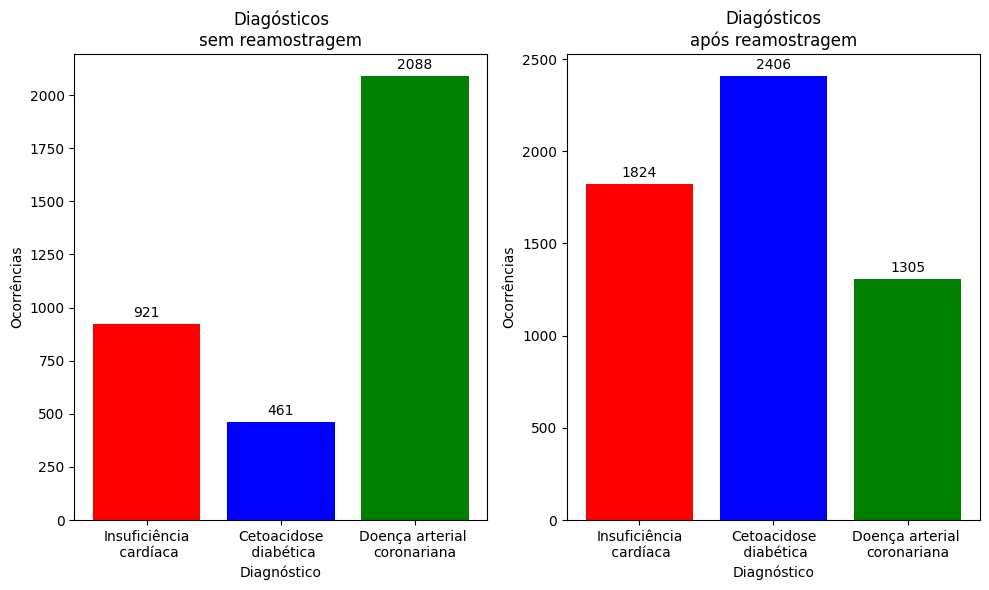

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

dist = {'Insuficiência\n cardíaca': [1824],
        'Cetoacidose\n diabética': [2406],
        'Doença arterial \ncoronariana': [1305]}
cores = ['red', 'blue', 'green']
classes = list(dist.keys())
alturas = [valor[0] for valor in dist.values()]

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
barras = axs[1].bar(classes, alturas, color=cores)
axs[1].set_xlabel('Diagnóstico')
axs[1].set_ylabel('Ocorrências')
axs[1].set_title('Diagósticos\napós reamostragem')
for barra in barras:
    altura = barra.get_height()
    axs[1].annotate('{}'.format(altura),
                xy=(barra.get_x() + barra.get_width() / 2, altura),
                xytext=(0, 3),  # 3 pontos de compensação para cima
                textcoords="offset points",
                ha='center', va='bottom')


dist = {'Insuficiência\n cardíaca': [df[df['DIAGNOSIS']=='CONGESTIVE HEART FAILURE'].shape[0]],
        'Cetoacidose\n diabética': [df[df['DIAGNOSIS']=='DIABETIC KETOACIDOSIS'].shape[0]],
        'Doença arterial \ncoronariana': [df[df['DIAGNOSIS']=='CORONARY ARTERY DISEASE'].shape[0]]}

cores = ['red', 'blue', 'green']
classes = list(dist.keys())
alturas = [valor[0] for valor in dist.values()]

barras = axs[0].bar(classes, alturas, color=cores)
axs[0].set_xlabel('Diagnóstico')
axs[0].set_ylabel('Ocorrências')
axs[0].set_title('Diagósticos\nsem reamostragem')
for barra in barras:
    altura = barra.get_height()
    axs[0].annotate('{}'.format(altura),
                xy=(barra.get_x() + barra.get_width() / 2, altura),
                xytext=(0, 3),  # 3 pontos de compensação para cima
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

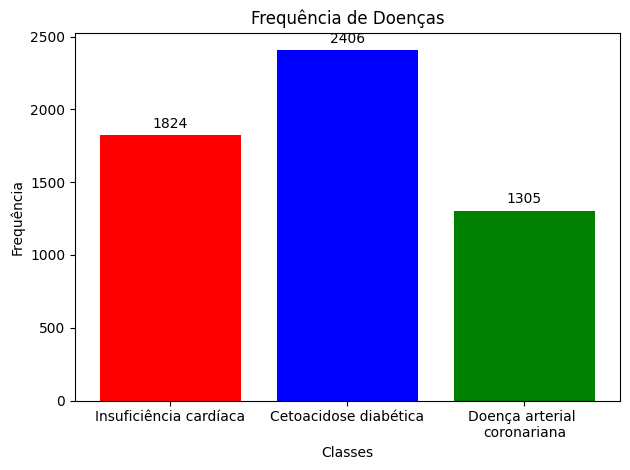

In [36]:
import matplotlib.pyplot as plt

# Dados
dist = {'Insuficiência cardíaca': [1824],
        'Cetoacidose diabética': [2406],
        'Doença arterial \ncoronariana': [1305]}

# Cores das barras
cores = ['red', 'blue', 'green']

# Extrair nomes das classes e alturas das barras
classes = list(dist.keys())
alturas = [valor[0] for valor in dist.values()]

# Configurar o gráfico
fig, ax = plt.subplots()
barras = ax.bar(classes, alturas, color=cores)

# Adicionar rótulos e título
ax.set_xlabel('Classes')
ax.set_ylabel('Frequência')
ax.set_title('Frequência de Doenças')

# Adicionar o valor numérico acima de cada barra
for barra in barras:
    altura = barra.get_height()
    ax.annotate('{}'.format(altura),
                xy=(barra.get_x() + barra.get_width() / 2, altura),
                xytext=(0, 3),  # 3 pontos de compensação para cima
                textcoords="offset points",
                ha='center', va='bottom')

# Ajustar o layout para evitar cortar o nome das classes
plt.tight_layout()

# Exibir o gráfico
plt.show()


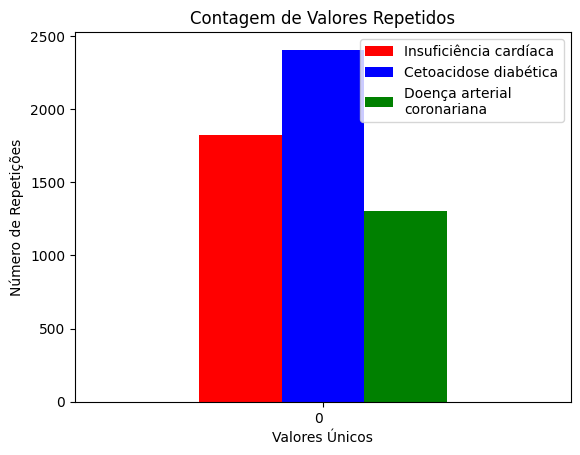

In [37]:
dist = {'Insuficiência cardíaca':[1824],
        'Cetoacidose diabética':[2406],
        'Doença arterial \ncoronariana':[1305]}
dist =pd.DataFrame(dist)
ax = dist.plot(kind='bar', color=['red', 'blue', 'green'])

plt.title('Contagem de Valores Repetidos')
plt.xlabel('Valores Únicos')
plt.ylabel('Número de Repetições')


ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')

# Exibir o gráfico
plt.show()

<ipython-input-38-02eafdea7c82>:26: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d1 = int(groupedData[groupedData['DIAGNOSIS'] == 'CONGESTIVE HEART FAILURE'][turn].fillna(0))
<ipython-input-38-02eafdea7c82>:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d2 = int(groupedData[groupedData['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE'][turn].fillna(0))
<ipython-input-38-02eafdea7c82>:35: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d3 = int(groupedData[groupedData['DIAGNOSIS'] == 'DIABETIC KETOACIDOSIS'][turn].fillna(0))
<ipython-input-38-02eafdea7c82>:26: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d1 = int(group

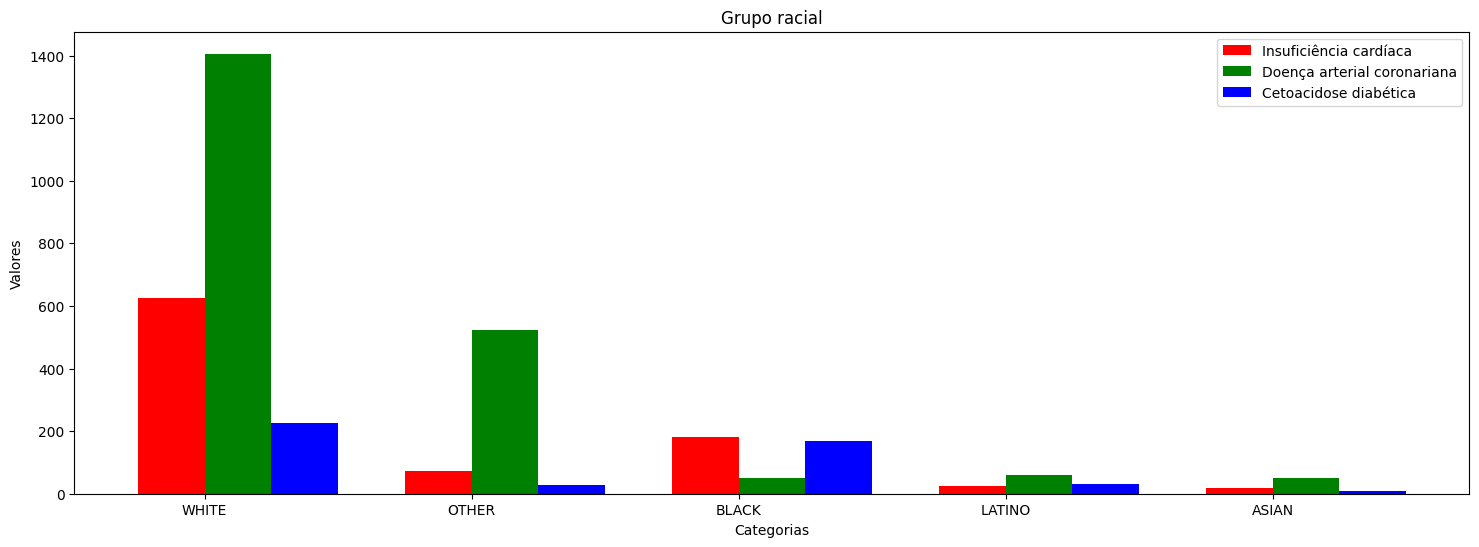

In [38]:
import matplotlib.pyplot as plt
import numpy as np
def getGraphic(data):
  categorias = data['Classe']
  valores1 = data['CONGESTIVE HEART FAILURE']
  valores2 = data['CORONARY ARTERY DISEASE']
  valores3 = data['DIABETIC KETOACIDOSIS']
  cores = ['red', 'green', 'blue']
  largura_barra = 0.25
  posicoes1 = np.arange(len(categorias))
  posicoes2 = posicoes1 + largura_barra
  plt.figure(figsize=(18, 6))
  plt.bar(posicoes1, valores1, largura_barra, color=cores[0], label='Insuficiência cardíaca')
  plt.bar(posicoes2, valores2, largura_barra, color=cores[1], label='Doença arterial coronariana')
  plt.bar(posicoes2+largura_barra, valores3, largura_barra, color=cores[2], label='Cetoacidose diabética')
  plt.xlabel('Categorias')
  plt.ylabel('Valores')
  plt.title('Grupo racial')
  plt.xticks(posicoes1 + largura_barra / 2, categorias)
  plt.legend()
  plt.show()
def getData(data,key,turn,finalData):
  data = data[data[turn] == key]
  groupedData = data.groupby('DIAGNOSIS').count()[turn].reset_index()
  try:
    d1 = int(groupedData[groupedData['DIAGNOSIS'] == 'CONGESTIVE HEART FAILURE'][turn].fillna(0))
  except:
    d1=0
  try:
    d2 = int(groupedData[groupedData['DIAGNOSIS'] == 'CORONARY ARTERY DISEASE'][turn].fillna(0))
  except:
    d2=0

  try:
    d3 = int(groupedData[groupedData['DIAGNOSIS'] == 'DIABETIC KETOACIDOSIS'][turn].fillna(0))
  except:
    d3=0

  finalData['Grupo'].append(turn)
  finalData['Classe'].append(key)
  finalData['CONGESTIVE HEART FAILURE'].append(d1)
  finalData['CORONARY ARTERY DISEASE'].append(d2)
  finalData['DIABETIC KETOACIDOSIS'].append(d3)
  return finalData
plotData = {
             'Grupo':[],
             'Classe':[],
             'CONGESTIVE HEART FAILURE':[],
             'CORONARY ARTERY DISEASE':[],
             'DIABETIC KETOACIDOSIS':[]
            }
# 'GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS'
for i in range(len(dfs)):
  for key in dfs[i][0]['Reduced_ETHNICITY'].unique():
    if type(key) != float :
      plotData = getData(dfs[i][0],str(key),'Reduced_ETHNICITY',plotData)
pd.DataFrame(plotData)
getGraphic(pd.DataFrame(plotData))

# preprocessing Gradient Boosting



## Congestive hearth failure

In [51]:
protAttr

'Coded MARITAL_STATUS'

In [52]:
temp = reffDf[reffDf['Attr'] == protAttr]
temp

,Attr,source,Coded
7,Coded MARITAL_STATUS,MARRIED,1
8,Coded MARITAL_STATUS,WIDOWED,5
9,Coded MARITAL_STATUS,UNKNOWN,4
10,Coded MARITAL_STATUS,SINGLE,3
11,Coded MARITAL_STATUS,DIVORCED,0
12,Coded MARITAL_STATUS,SEPARATED,2


In [53]:
!pip install fairlearn
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CONGESTIVE HEART FAILURE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)


    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.87

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.86      0.91       512
        True       0.70      0.92      0.79       182

    accuracy                           0.87       694
   macro avg       0.83      0.89      0.85       694
weighted avg       0.90      0.87      0.88       694



# Atributo sensível: Coded Reduced_ETHNICITY

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.88

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.95      0.89      0.92       512
        True       0.73      0.87      0.80       182

    accuracy                           0.88       694
   macro avg       0.84      0.88      0.86       694
weighted avg       0.89      0.88      0.89       694



# Atributo sensível: Coded INSURANCE

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.88      0.92       512
        True       0.73      0.92      0.81       182

    accuracy                           0.89       694
   macro avg       0.85      0.90      0.87       694
weighted avg       0.91      0.89      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

Acurácia: 0.88

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.88      0.92       512
        True       0.72      0.90      0.80       182

    accuracy                           0.88       694
   macro avg       0.84      0.89      0.86       694
weighted avg       0.90      0.88      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.8875,0.9149,0.8875,0.8938,0.9400,0.1267
1,F,0.8430,0.8575,0.8430,0.8454,0.8902,0.1844
2,OTHER,0.8455,0.9073,0.8455,0.8664,0.7692,0.1455
3,WHITE,0.8931,0.8985,0.8931,0.8948,0.8618,0.0951
4,BLACK,0.8500,0.8591,0.8500,0.8497,0.9211,0.2143
5,LATINO,0.9630,0.9683,0.9630,0.9639,1.0000,0.0476
6,ASIAN,0.9333,0.9556,0.9333,0.9387,1.0000,0.0769
7,Medicare,0.8662,0.8861,0.8662,0.8685,0.9441,0.1779
8,Private,0.9144,0.9276,0.9144,0.9195,0.7273,0.0650
9,Government,0.9412,0.9706,0.9412,0.9500,1.0000,0.0625


In [54]:
pd.set_option('display.float_format', '{:.4f}'.format)
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.887473 & 0.914907 & 0.887473 & 0.893755 & 0.940000 & 0.126685 \\
F & 0.843049 & 0.857537 & 0.843049 & 0.845386 & 0.890244 & 0.184397 \\
OTHER & 0.845528 & 0.907300 & 0.845528 & 0.866423 & 0.769231 & 0.145455 \\
WHITE & 0.893096 & 0.898452 & 0.893096 & 0.894801 & 0.861789 & 0.095092 \\
BLACK & 0.850000 & 0.859091 & 0.850000 & 0.849719 & 0.921053 & 0.214286 \\
LATINO & 0.962963 & 0.968254 & 0.962963 & 0.963936 & 1.000000 & 0.047619 \\
ASIAN & 0.933333 & 0.955556 & 0.933333 & 0.938667 & 1.000000 & 0.076923 \\
Medicare & 0.866162 & 0.886060 & 0.866162 & 0.868548 & 0.944056 & 0.177866 \\
Private & 0.914414 & 0.927569 & 0.914414 & 0.919526 & 0.727273 & 0.065000 \\
Government & 0.941176 & 0.970588 & 0.941176 & 0.950032 & 1.000000 & 0.062500 \\
Medicaid & 0.928571 & 0.942857 & 0.928571 & 0.930660 & 1.000000 & 0.100000 \\
MARRIED & 0.887052 & 0.910002 & 0.887

In [55]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 94 & 324 & 47 & 6 \\
F & 73 & 115 & 26 & 9 \\
OTHER & 10 & 94 & 16 & 3 \\
WHITE & 106 & 295 & 31 & 17 \\
BLACK & 35 & 33 & 9 & 3 \\
LATINO & 6 & 20 & 1 & 0 \\
ASIAN & 2 & 12 & 1 & 0 \\
Medicare & 135 & 208 & 45 & 8 \\
Private & 16 & 187 & 13 & 6 \\
Government & 1 & 15 & 1 & 0 \\
Medicaid & 16 & 36 & 4 & 0 \\
MARRIED & 58 & 264 & 33 & 8 \\
SINGLE & 37 & 108 & 12 & 5 \\
WIDOWED & 48 & 40 & 10 & 4 \\
UNKNOWN & 3 & 12 & 1 & 2 \\
DIVORCED & 9 & 21 & 7 & 0 \\
SEPARATED & 8 & 4 & 0 & 0 \\
\bottomrule
\end{tabular}



## Cetoacidose diabética

In [56]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.96

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       604
        True       0.82      0.91      0.86        90

    accuracy                           0.96       694
   macro avg       0.90      0.94      0.92       694
weighted avg       0.96      0.96      0.96       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       604
        True       0.83      0.96      0.89        90

    accuracy                           0.97       694
   macro avg       0.91      0.96      0.94       694
weighted avg       0.97      0.97      0.97       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded INSURANCE

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       604
        True       0.86      0.94      0.90        90

    accuracy                           0.97       694
   macro avg       0.93      0.96      0.94       694
weighted avg       0.97      0.97      0.97       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-56-43c2a0de256a>:23: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-56-43c2a0de256a>:23: RuntimeWarning: invalid value encountered 

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       604
        True       0.85      0.94      0.89        90

    accuracy                           0.97       694
   macro avg       0.92      0.96      0.94       694
weighted avg       0.97      0.97      0.97       694



,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.9639,0.9706,0.9639,0.9660,0.9189,0.0323
1,F,0.9596,0.9594,0.9596,0.9595,0.9057,0.0235
2,OTHER,0.9675,0.9734,0.9675,0.9697,0.8333,0.0256
3,WHITE,0.9755,0.9781,0.9755,0.9763,0.9556,0.0223
4,BLACK,0.9250,0.9310,0.9250,0.9257,0.9677,0.1020
5,LATINO,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.9722,0.9751,0.9722,0.9732,0.8966,0.0218
8,Private,0.9685,0.9703,0.9685,0.9691,0.9355,0.0262
9,Government,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000


In [57]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.963907 & 0.970553 & 0.963907 & 0.966010 & 0.918919 & 0.032258 \\
F & 0.959641 & 0.959427 & 0.959641 & 0.959508 & 0.905660 & 0.023529 \\
OTHER & 0.967480 & 0.973436 & 0.967480 & 0.969662 & 0.833333 & 0.025641 \\
WHITE & 0.975501 & 0.978121 & 0.975501 & 0.976278 & 0.955556 & 0.022277 \\
BLACK & 0.925000 & 0.931032 & 0.925000 & 0.925677 & 0.967742 & 0.102041 \\
LATINO & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.972222 & 0.975088 & 0.972222 & 0.973229 & 0.896552 & 0.021798 \\
Private & 0.968468 & 0.970312 & 0.968468 & 0.969071 & 0.935484 & 0.026178 \\
Government & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicaid & 0.982143 & 0.983036 & 0.982143 & 0.982249 & 1.000000 & 0.027027 \\
Self Pay & 1.000000 & 1.000000 & 1.00

In [58]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 34 & 420 & 14 & 3 \\
F & 48 & 166 & 4 & 5 \\
OTHER & 5 & 114 & 3 & 1 \\
WHITE & 43 & 395 & 9 & 2 \\
BLACK & 30 & 44 & 5 & 1 \\
LATINO & 6 & 21 & 0 & 0 \\
ASIAN & 2 & 13 & 0 & 0 \\
Medicare & 26 & 359 & 8 & 3 \\
Private & 29 & 186 & 5 & 2 \\
Government & 9 & 8 & 0 & 0 \\
Medicaid & 19 & 36 & 1 & 0 \\
Self Pay & 2 & 1 & 0 & 0 \\
MARRIED & 20 & 336 & 6 & 1 \\
SINGLE & 55 & 100 & 3 & 4 \\
WIDOWED & 2 & 98 & 2 & 0 \\
UNKNOWN & 0 & 16 & 2 & 0 \\
DIVORCED & 8 & 29 & 0 & 0 \\
SEPARATED & 0 & 10 & 2 & 0 \\
\bottomrule
\end{tabular}



## Doença arterial coronariana

In [59]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test,p_train,p_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease],df[CodedProtectedAttrs],
                                                                     test_size=0.2, random_state=42)




  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test[protAttr] = p_test
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.91

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.88      0.88      0.88       272
        True       0.92      0.92      0.92       422

    accuracy                           0.91       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.91      0.91      0.91       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.90

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.87      0.88      0.88       272
        True       0.92      0.91      0.92       422

    accuracy                           0.90       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.90      0.90      0.90       694



# Atributo sensível: Coded INSURANCE

Acurácia: 0.90

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.88      0.88      0.88       272
        True       0.92      0.92      0.92       422

    accuracy                           0.90       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.91      0.90      0.90       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.91

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.88      0.90      0.89       272
        True       0.94      0.92      0.93       422

    accuracy                           0.91       694
   macro avg       0.91      0.91      0.91       694
weighted avg       0.91      0.91      0.91       694



,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.9130,0.9147,0.9130,0.9136,0.9281,0.1241
1,F,0.8924,0.8948,0.8924,0.8929,0.8977,0.1111
2,OTHER,0.8943,0.9144,0.8943,0.9007,0.9038,0.1579
3,WHITE,0.8909,0.8907,0.8909,0.8908,0.9146,0.1488
4,BLACK,0.9375,0.9476,0.9375,0.9406,0.9091,0.0580
5,LATINO,0.9630,0.9658,0.9630,0.9631,0.9333,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.8864,0.8867,0.8864,0.8865,0.8929,0.1221
8,Private,0.9279,0.9290,0.9279,0.9284,0.9467,0.1321
9,Government,0.9412,0.9485,0.9412,0.9416,1.0000,0.1000


In [60]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.912951 & 0.914656 & 0.912951 & 0.913574 & 0.928144 & 0.124088 \\
F & 0.892377 & 0.894793 & 0.892377 & 0.892928 & 0.897727 & 0.111111 \\
OTHER & 0.894309 & 0.914438 & 0.894309 & 0.900689 & 0.903846 & 0.157895 \\
WHITE & 0.890869 & 0.890746 & 0.890869 & 0.890803 & 0.914591 & 0.148810 \\
BLACK & 0.937500 & 0.947646 & 0.937500 & 0.940556 & 0.909091 & 0.057971 \\
LATINO & 0.962963 & 0.965812 & 0.962963 & 0.963065 & 0.933333 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.886364 & 0.886683 & 0.886364 & 0.886472 & 0.892857 & 0.122093 \\
Private & 0.927928 & 0.929025 & 0.927928 & 0.928381 & 0.946746 & 0.132075 \\
Government & 0.941176 & 0.948529 & 0.941176 & 0.941589 & 1.000000 & 0.100000 \\
Medicaid & 0.928571 & 0.932148 & 0.928571 & 0.929144 & 0.952381 & 0.085714 \\
Self Pay & 1.000000 & 1.000000 & 1.00

In [61]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 310 & 120 & 17 & 24 \\
F & 79 & 120 & 15 & 9 \\
OTHER & 94 & 16 & 3 & 10 \\
WHITE & 257 & 143 & 25 & 24 \\
BLACK & 10 & 65 & 4 & 1 \\
LATINO & 14 & 12 & 0 & 1 \\
ASIAN & 11 & 4 & 0 & 0 \\
Medicare & 200 & 151 & 21 & 24 \\
Private & 160 & 46 & 7 & 9 \\
Government & 7 & 9 & 1 & 0 \\
Medicaid & 20 & 32 & 3 & 1 \\
Self Pay & 1 & 2 & 0 & 0 \\
MARRIED & 257 & 74 & 13 & 19 \\
SINGLE & 55 & 97 & 4 & 6 \\
WIDOWED & 45 & 46 & 8 & 3 \\
UNKNOWN & 10 & 4 & 1 & 3 \\
DIVORCED & 18 & 17 & 0 & 2 \\
SEPARATED & 4 & 7 & 1 & 0 \\
\bottomrule
\end{tabular}



# postprocessing Gradient Boosting

In [62]:
pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.3 MB/s eta 0:00:00


## Insuficiencia

In [63]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CONGESTIVE HEART FAILURE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  # accuracy = accuracy_score(y_test, y_pred)
  # report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  # print(f'Acurácia: {accuracy:.2f}')
  # print('\nRelatório de Classificação:')
  # print(report)


  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)

pip install 'aif360[inFairness]'


# Atributo sensível: Coded GENDER

0.8876080691642652 0.7260869565217392


# Atributo sensível: Coded Reduced_ETHNICITY

0.8876080691642652 0.7300884955752213


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded INSURANCE

0.8890489913544669 0.7253218884120172


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:175: RuntimeWarning: invalid value encountered in scalar divide
  A_eq = [[(np.mean(sconst*sm_tp) - np.mean(sflip*sm_tp)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:176: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(sflip*sm_fn) - np.mean(sconst*sm_fn)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:185: RuntimeWarning: invalid value encountered in scalar d

# Atributo sensível: Coded MARITAL_STATUS

0.8789625360230547 0.7094017094017094


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.8344,0.8879,0.8344,0.8464,0.9200,0.1887
1,F,0.8430,0.8602,0.8430,0.8455,0.9024,0.1915
2,OTHER,0.8943,0.7998,0.8943,0.8444,0.0000,0.0000
3,WHITE,0.8953,0.9056,0.8953,0.8979,0.9024,0.1074
4,BLACK,0.5250,0.2756,0.5250,0.3615,0.0000,0.0000
5,LATINO,0.7778,0.6049,0.7778,0.6806,0.0000,0.0000
6,ASIAN,0.9333,0.9556,0.9333,0.9387,1.0000,0.0769
7,MARRIED,0.8788,0.9085,0.8788,0.8868,0.8939,0.1246
8,SINGLE,0.7407,0.5487,0.7407,0.6304,0.0000,0.0000
9,WIDOWED,0.4902,0.2403,0.4902,0.3225,0.0000,0.0000


In [64]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.834395 & 0.887866 & 0.834395 & 0.846440 & 0.920000 & 0.188679 \\
F & 0.843049 & 0.860239 & 0.843049 & 0.845528 & 0.902439 & 0.191489 \\
OTHER & 0.894309 & 0.799788 & 0.894309 & 0.844412 & 0.000000 & 0.000000 \\
WHITE & 0.895323 & 0.905574 & 0.895323 & 0.897884 & 0.902439 & 0.107362 \\
BLACK & 0.525000 & 0.275625 & 0.525000 & 0.361475 & 0.000000 & 0.000000 \\
LATINO & 0.777778 & 0.604938 & 0.777778 & 0.680556 & 0.000000 & 0.000000 \\
ASIAN & 0.933333 & 0.955556 & 0.933333 & 0.938667 & 1.000000 & 0.076923 \\
MARRIED & 0.878788 & 0.908474 & 0.878788 & 0.886787 & 0.893939 & 0.124579 \\
SINGLE & 0.740741 & 0.548697 & 0.740741 & 0.630418 & 0.000000 & 0.000000 \\
WIDOWED & 0.490196 & 0.240292 & 0.490196 & 0.322497 & 0.000000 & 0.000000 \\
UNKNOWN & 0.722222 & 0.521605 & 0.722222 & 0.605735 & 0.000000 & 0.000000 \\
DIVORCED & 0.756757 & 0.572681 & 0.756757 &

In [65]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 92 & 301 & 70 & 8 \\
F & 74 & 114 & 27 & 8 \\
OTHER & 0 & 110 & 0 & 13 \\
WHITE & 111 & 291 & 35 & 12 \\
BLACK & 0 & 42 & 0 & 38 \\
LATINO & 0 & 21 & 0 & 6 \\
ASIAN & 2 & 12 & 1 & 0 \\
MARRIED & 59 & 260 & 37 & 7 \\
SINGLE & 0 & 120 & 0 & 42 \\
WIDOWED & 0 & 50 & 0 & 52 \\
UNKNOWN & 0 & 13 & 0 & 5 \\
DIVORCED & 0 & 28 & 0 & 9 \\
SEPARATED & 8 & 4 & 0 & 0 \\
\bottomrule
\end{tabular}



##DKA

In [66]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  # accuracy = accuracy_score(y_test, y_pred)
  # report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  # print(f'Acurácia: {accuracy:.2f}')
  # print('\nRelatório de Classificação:')
  # print(report)


  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)


pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

0.9697406340057637 0.8415841584158416


# Atributo sensível: Coded Reduced_ETHNICITY

0.9654178674351584 0.8173076923076923


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded INSURANCE

0.9755043227665706 0.8762886597938144


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded MARITAL_STATUS

0.9740634005763689 0.8673469387755102


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:175: RuntimeWarning: invalid value encountered in scalar divide
  A_eq = [[(np.mean(sconst*sm_tp) - np.mean(sflip*sm_tp)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:176: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(sflip*sm_fn) - np.mean(sconst*sm_fn)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:185: RuntimeWarning: invalid value encountered in scalar d

,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.9533,0.9670,0.9533,0.9574,0.9459,0.0461
1,F,0.9507,0.9534,0.9507,0.9514,0.9434,0.0471
2,OTHER,0.9512,0.9048,0.9512,0.9274,0.0000,0.0000
3,WHITE,0.9733,0.9765,0.9733,0.9742,0.9556,0.0248
4,BLACK,0.6125,0.3752,0.6125,0.4653,0.0000,0.0000
5,LATINO,0.7778,0.6049,0.7778,0.6806,0.0000,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.9773,0.9798,0.9773,0.9781,0.9310,0.0191
8,Private,0.8604,0.7402,0.8604,0.7958,0.0000,0.0000
9,Government,0.4706,0.2215,0.4706,0.3012,0.0000,0.0000


In [67]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.953291 & 0.967004 & 0.953291 & 0.957366 & 0.945946 & 0.046083 \\
F & 0.950673 & 0.953358 & 0.950673 & 0.951416 & 0.943396 & 0.047059 \\
OTHER & 0.951220 & 0.904819 & 0.951220 & 0.927439 & 0.000000 & 0.000000 \\
WHITE & 0.973274 & 0.976546 & 0.973274 & 0.974231 & 0.955556 & 0.024752 \\
BLACK & 0.612500 & 0.375156 & 0.612500 & 0.465310 & 0.000000 & 0.000000 \\
LATINO & 0.777778 & 0.604938 & 0.777778 & 0.680556 & 0.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.977273 & 0.979802 & 0.977273 & 0.978097 & 0.931034 & 0.019074 \\
Private & 0.860360 & 0.740220 & 0.860360 & 0.795781 & 0.000000 & 0.000000 \\
Government & 0.470588 & 0.221453 & 0.470588 & 0.301176 & 0.000000 & 0.000000 \\
Medicaid & 0.660714 & 0.436543 & 0.660714 & 0.525730 & 0.000000 & 0.000000 \\
Self Pay & 1.000000 & 1.000000 & 1.00

In [68]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 35 & 414 & 20 & 2 \\
F & 50 & 162 & 8 & 3 \\
OTHER & 0 & 117 & 0 & 6 \\
WHITE & 43 & 394 & 10 & 2 \\
BLACK & 0 & 49 & 0 & 31 \\
LATINO & 0 & 21 & 0 & 6 \\
ASIAN & 2 & 13 & 0 & 0 \\
Medicare & 27 & 360 & 7 & 2 \\
Private & 0 & 191 & 0 & 31 \\
Government & 0 & 8 & 0 & 9 \\
Medicaid & 0 & 37 & 0 & 19 \\
Self Pay & 2 & 1 & 0 & 0 \\
\bottomrule
\end{tabular}



## Doença coronariana



In [69]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  # accuracy = accuracy_score(y_test, y_pred)
  # report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  # print(f'Acurácia: {accuracy:.2f}')
  # print('\nRelatório de Classificação:')
  # print(report)


  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)


pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

0.9221902017291066 0.948780487804878


# Atributo sensível: Coded Reduced_ETHNICITY

0.9048991354466859 0.9341463414634147


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded INSURANCE

0.8976945244956772 0.9168646080760094


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded MARITAL_STATUS

0.9106628242074928 0.9368932038834952


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.8641,0.8841,0.8641,0.8683,0.8473,0.0949
1,F,0.9013,0.9011,0.9013,0.9011,0.8636,0.0741
2,OTHER,0.1545,0.0239,0.1545,0.0413,0.0000,0.0000
3,WHITE,0.9020,0.9017,0.9020,0.9018,0.9288,0.1429
4,BLACK,0.8625,0.7439,0.8625,0.7988,0.0000,0.0000
5,LATINO,0.4444,0.1975,0.4444,0.2735,0.0000,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.7652,0.7865,0.7652,0.7533,0.9330,0.4535
8,Private,0.2387,0.0570,0.2387,0.0920,0.0000,0.0000
9,Government,0.5882,0.3460,0.5882,0.4357,0.0000,0.0000


In [70]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.864119 & 0.884088 & 0.864119 & 0.868296 & 0.847305 & 0.094891 \\
F & 0.901345 & 0.901088 & 0.901345 & 0.901141 & 0.863636 & 0.074074 \\
OTHER & 0.154472 & 0.023861 & 0.154472 & 0.041337 & 0.000000 & 0.000000 \\
WHITE & 0.902004 & 0.901668 & 0.902004 & 0.901760 & 0.928826 & 0.142857 \\
BLACK & 0.862500 & 0.743906 & 0.862500 & 0.798826 & 0.000000 & 0.000000 \\
LATINO & 0.444444 & 0.197531 & 0.444444 & 0.273504 & 0.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.765152 & 0.786496 & 0.765152 & 0.753302 & 0.933036 & 0.453488 \\
Private & 0.238739 & 0.056996 & 0.238739 & 0.092023 & 0.000000 & 0.000000 \\
Government & 0.588235 & 0.346021 & 0.588235 & 0.435730 & 0.000000 & 0.000000 \\
Medicaid & 0.625000 & 0.390625 & 0.625000 & 0.480769 & 0.000000 & 0.000000 \\
Self Pay & 0.666667 & 0.833333 & 0.66

In [71]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 283 & 124 & 13 & 51 \\
F & 76 & 125 & 10 & 12 \\
OTHER & 0 & 19 & 0 & 104 \\
WHITE & 261 & 144 & 24 & 20 \\
BLACK & 0 & 69 & 0 & 11 \\
LATINO & 0 & 12 & 0 & 15 \\
ASIAN & 11 & 4 & 0 & 0 \\
Medicare & 209 & 94 & 78 & 15 \\
Private & 0 & 53 & 0 & 169 \\
Government & 0 & 10 & 0 & 7 \\
Medicaid & 0 & 35 & 0 & 21 \\
Self Pay & 1 & 1 & 1 & 0 \\
MARRIED & 258 & 73 & 14 & 18 \\
SINGLE & 0 & 101 & 0 & 61 \\
WIDOWED & 0 & 54 & 0 & 48 \\
UNKNOWN & 0 & 5 & 0 & 13 \\
DIVORCED & 0 & 17 & 0 & 20 \\
SEPARATED & 4 & 7 & 1 & 0 \\
\bottomrule
\end{tabular}



# Pre processing SVM

## Insuficiencia

In [72]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CONGESTIVE HEART FAILURE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = SVC(kernel='linear')
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)


    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.88

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.87      0.92       512
        True       0.72      0.91      0.80       182

    accuracy                           0.88       694
   macro avg       0.84      0.89      0.86       694
weighted avg       0.90      0.88      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.88      0.92       512
        True       0.73      0.91      0.81       182

    accuracy                           0.89       694
   macro avg       0.85      0.90      0.87       694
weighted avg       0.90      0.89      0.89       694



# Atributo sensível: Coded INSURANCE

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Acurácia: 0.88

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.88      0.92       512
        True       0.72      0.91      0.80       182

    accuracy                           0.88       694
   macro avg       0.84      0.89      0.86       694
weighted avg       0.90      0.88      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Acurácia: 0.88

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.87      0.91       512
        True       0.71      0.90      0.79       182

    accuracy                           0.88       694
   macro avg       0.84      0.89      0.85       694
weighted avg       0.90      0.88      0.88       694



,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.8938,0.9148,0.8938,0.8990,0.9200,0.1132
1,F,0.8565,0.8671,0.8565,0.8584,0.8902,0.1631
2,OTHER,0.8618,0.9302,0.8618,0.8820,0.9231,0.1455
3,WHITE,0.8998,0.9111,0.8998,0.9024,0.9187,0.1074
4,BLACK,0.8250,0.8291,0.8250,0.8250,0.8684,0.2143
5,LATINO,0.9630,0.9683,0.9630,0.9639,1.0000,0.0476
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.8510,0.8695,0.8510,0.8536,0.9161,0.1858
8,Private,0.9234,0.9437,0.9234,0.9300,0.8636,0.0700
9,Government,0.9412,0.8858,0.9412,0.9127,0.0000,0.0000


In [73]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.893843 & 0.914755 & 0.893843 & 0.899006 & 0.920000 & 0.113208 \\
F & 0.856502 & 0.867094 & 0.856502 & 0.858397 & 0.890244 & 0.163121 \\
OTHER & 0.861789 & 0.930191 & 0.861789 & 0.882015 & 0.923077 & 0.145455 \\
WHITE & 0.899777 & 0.911095 & 0.899777 & 0.902402 & 0.918699 & 0.107362 \\
BLACK & 0.825000 & 0.829135 & 0.825000 & 0.825000 & 0.868421 & 0.214286 \\
LATINO & 0.962963 & 0.968254 & 0.962963 & 0.963936 & 1.000000 & 0.047619 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.851010 & 0.869482 & 0.851010 & 0.853597 & 0.916084 & 0.185771 \\
Private & 0.923423 & 0.943658 & 0.923423 & 0.929998 & 0.863636 & 0.070000 \\
Government & 0.941176 & 0.885813 & 0.941176 & 0.912656 & 0.000000 & 0.000000 \\
Medicaid & 0.946429 & 0.948072 & 0.946429 & 0.946901 & 0.937500 & 0.050000 \\
MARRIED & 0.887052 & 0.912317 & 0.887

In [74]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 92 & 329 & 42 & 8 \\
F & 73 & 118 & 23 & 9 \\
OTHER & 12 & 94 & 16 & 1 \\
WHITE & 113 & 291 & 35 & 10 \\
BLACK & 33 & 33 & 9 & 5 \\
LATINO & 6 & 20 & 1 & 0 \\
ASIAN & 2 & 13 & 0 & 0 \\
Medicare & 131 & 206 & 47 & 12 \\
Private & 19 & 186 & 14 & 3 \\
Government & 0 & 16 & 0 & 1 \\
Medicaid & 15 & 38 & 2 & 1 \\
MARRIED & 59 & 263 & 34 & 7 \\
SINGLE & 39 & 105 & 15 & 3 \\
WIDOWED & 47 & 41 & 9 & 5 \\
UNKNOWN & 4 & 10 & 3 & 1 \\
DIVORCED & 9 & 22 & 6 & 0 \\
SEPARATED & 6 & 4 & 0 & 2 \\
\bottomrule
\end{tabular}



## DKA

In [75]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = SVC(kernel='linear')
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       604
        True       0.83      0.96      0.89        90

    accuracy                           0.97       694
   macro avg       0.91      0.96      0.93       694
weighted avg       0.97      0.97      0.97       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       604
        True       0.81      0.98      0.88        90

    accuracy                           0.97       694
   macro avg       0.90      0.97      0.93       694
weighted avg       0.97      0.97      0.97       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded INSURANCE

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       604
        True       0.82      0.98      0.89        90

    accuracy                           0.97       694
   macro avg       0.91      0.97      0.94       694
weighted avg       0.97      0.97      0.97       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-75-eb9bf0eaa80f>:23: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-75-eb9bf0eaa80f>:23: RuntimeWarning: invalid value encountered in scalar divide
  retu

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       604
        True       0.85      0.97      0.91        90

    accuracy                           0.97       694
   macro avg       0.92      0.97      0.95       694
weighted avg       0.98      0.97      0.97       694



,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.9766,0.9808,0.9766,0.9778,0.9730,0.0230
1,F,0.9507,0.9534,0.9507,0.9514,0.9434,0.0471
2,OTHER,0.9756,0.9837,0.9756,0.9779,1.0000,0.0256
3,WHITE,0.9755,0.9792,0.9755,0.9765,0.9778,0.0248
4,BLACK,0.8875,0.9038,0.8875,0.8889,0.9677,0.1633
5,LATINO,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.9672,0.9754,0.9672,0.9695,0.9655,0.0327
8,Private,0.9640,0.9689,0.9640,0.9653,0.9677,0.0366
9,Government,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000


In [76]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.976645 & 0.980754 & 0.976645 & 0.977789 & 0.972973 & 0.023041 \\
F & 0.950673 & 0.953358 & 0.950673 & 0.951416 & 0.943396 & 0.047059 \\
OTHER & 0.975610 & 0.983740 & 0.975610 & 0.977890 & 1.000000 & 0.025641 \\
WHITE & 0.975501 & 0.979162 & 0.975501 & 0.976477 & 0.977778 & 0.024752 \\
BLACK & 0.887500 & 0.903838 & 0.887500 & 0.888880 & 0.967742 & 0.163265 \\
LATINO & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.967172 & 0.975427 & 0.967172 & 0.969539 & 0.965517 & 0.032698 \\
Private & 0.963964 & 0.968931 & 0.963964 & 0.965266 & 0.967742 & 0.036649 \\
Government & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicaid & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Self Pay & 1.000000 & 1.000000 & 1.00

In [77]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 36 & 424 & 10 & 1 \\
F & 50 & 162 & 8 & 3 \\
OTHER & 6 & 114 & 3 & 0 \\
WHITE & 44 & 394 & 10 & 1 \\
BLACK & 30 & 41 & 8 & 1 \\
LATINO & 6 & 21 & 0 & 0 \\
ASIAN & 2 & 13 & 0 & 0 \\
Medicare & 28 & 355 & 12 & 1 \\
Private & 30 & 184 & 7 & 1 \\
Government & 9 & 8 & 0 & 0 \\
Medicaid & 19 & 37 & 0 & 0 \\
Self Pay & 2 & 1 & 0 & 0 \\
MARRIED & 20 & 334 & 8 & 1 \\
SINGLE & 57 & 101 & 2 & 2 \\
WIDOWED & 2 & 99 & 1 & 0 \\
UNKNOWN & 0 & 16 & 2 & 0 \\
DIVORCED & 8 & 29 & 0 & 0 \\
SEPARATED & 0 & 10 & 2 & 0 \\
\bottomrule
\end{tabular}



## Doença da arteria

In [78]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = SVC(kernel='linear')
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)


    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.90

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.87      0.89      0.88       272
        True       0.93      0.91      0.92       422

    accuracy                           0.90       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.91      0.90      0.91       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.85      0.89      0.87       272
        True       0.93      0.90      0.91       422

    accuracy                           0.89       694
   macro avg       0.89      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



# Atributo sensível: Coded INSURANCE

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.85      0.88      0.86       272
        True       0.92      0.90      0.91       422

    accuracy                           0.89       694
   macro avg       0.89      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.84      0.89      0.87       272
        True       0.93      0.89      0.91       422

    accuracy                           0.89       694
   macro avg       0.88      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.9130,0.9167,0.9130,0.9141,0.9192,0.1022
1,F,0.8879,0.8898,0.8879,0.8884,0.8864,0.1111
2,OTHER,0.9024,0.9324,0.9024,0.9101,0.8942,0.0526
3,WHITE,0.8886,0.8897,0.8886,0.8890,0.9004,0.1310
4,BLACK,0.8625,0.8790,0.8625,0.8692,0.6364,0.1014
5,LATINO,0.9630,0.9658,0.9630,0.9631,0.9333,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.8687,0.8705,0.8687,0.8690,0.8616,0.1221
8,Private,0.9324,0.9341,0.9324,0.9331,0.9467,0.1132
9,Government,0.8824,0.9085,0.8824,0.8832,1.0000,0.2000


In [79]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.912951 & 0.916716 & 0.912951 & 0.914059 & 0.919162 & 0.102190 \\
F & 0.887892 & 0.889784 & 0.887892 & 0.888383 & 0.886364 & 0.111111 \\
OTHER & 0.902439 & 0.932412 & 0.902439 & 0.910138 & 0.894231 & 0.052632 \\
WHITE & 0.888641 & 0.889723 & 0.888641 & 0.889017 & 0.900356 & 0.130952 \\
BLACK & 0.862500 & 0.878977 & 0.862500 & 0.869222 & 0.636364 & 0.101449 \\
LATINO & 0.962963 & 0.965812 & 0.962963 & 0.963065 & 0.933333 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.868687 & 0.870510 & 0.868687 & 0.869043 & 0.861607 & 0.122093 \\
Private & 0.932432 & 0.934116 & 0.932432 & 0.933060 & 0.946746 & 0.113208 \\
Government & 0.882353 & 0.908497 & 0.882353 & 0.883170 & 1.000000 & 0.200000 \\
Medicaid & 0.910714 & 0.912099 & 0.910714 & 0.911105 & 0.904762 & 0.085714 \\
Self Pay & 0.666667 & 0.833333 & 0.66

In [80]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 307 & 123 & 14 & 27 \\
F & 78 & 120 & 15 & 10 \\
OTHER & 93 & 18 & 1 & 11 \\
WHITE & 253 & 146 & 22 & 28 \\
BLACK & 7 & 62 & 7 & 4 \\
LATINO & 14 & 12 & 0 & 1 \\
ASIAN & 11 & 4 & 0 & 0 \\
Medicare & 193 & 151 & 21 & 31 \\
Private & 160 & 47 & 6 & 9 \\
Government & 7 & 8 & 2 & 0 \\
Medicaid & 19 & 32 & 3 & 2 \\
Self Pay & 1 & 1 & 1 & 0 \\
MARRIED & 250 & 74 & 13 & 26 \\
SINGLE & 54 & 93 & 8 & 7 \\
WIDOWED & 42 & 46 & 8 & 6 \\
UNKNOWN & 10 & 4 & 1 & 3 \\
DIVORCED & 17 & 17 & 0 & 3 \\
SEPARATED & 4 & 8 & 0 & 0 \\
\bottomrule
\end{tabular}



# postprocessing SVM

## Insuficiencia

In [81]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CONGESTIVE HEART FAILURE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = model = SVC(kernel='linear')
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred

  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

0.8804034582132565 0.7161572052401747


# Atributo sensível: Coded Reduced_ETHNICITY

0.8876080691642652 0.7241379310344828


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded INSURANCE

0.8832853025936599 0.7112970711297071


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:175: RuntimeWarning: invalid value encountered in scalar divide
  A_eq = [[(np.mean(sconst*sm_tp) - np.mean(sflip*sm_tp)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:176: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(sflip*sm_fn) - np.mean(sconst*sm_fn)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:185: RuntimeWarning: invalid value encountered in scalar d

# Atributo sensível: Coded MARITAL_STATUS

0.8760806916426513 0.7033898305084746


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.8217,0.8741,0.8217,0.8344,0.8800,0.1941
1,F,0.8386,0.8545,0.8386,0.8410,0.8902,0.1915
2,OTHER,0.8943,0.7998,0.8943,0.8444,0.0000,0.0000
3,WHITE,0.8976,0.9096,0.8976,0.9003,0.9187,0.1104
4,BLACK,0.5250,0.2756,0.5250,0.3615,0.0000,0.0000
5,LATINO,0.7778,0.6049,0.7778,0.6806,0.0000,0.0000
6,ASIAN,0.9333,0.9556,0.9333,0.9387,1.0000,0.0769
7,MARRIED,0.8926,0.9150,0.8926,0.8988,0.8939,0.1077
8,SINGLE,0.7407,0.5487,0.7407,0.6304,0.0000,0.0000
9,WIDOWED,0.4902,0.2403,0.4902,0.3225,0.0000,0.0000


In [82]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.821656 & 0.874066 & 0.821656 & 0.834389 & 0.880000 & 0.194070 \\
F & 0.838565 & 0.854453 & 0.838565 & 0.841045 & 0.890244 & 0.191489 \\
OTHER & 0.894309 & 0.799788 & 0.894309 & 0.844412 & 0.000000 & 0.000000 \\
WHITE & 0.897550 & 0.909611 & 0.897550 & 0.900319 & 0.918699 & 0.110429 \\
BLACK & 0.525000 & 0.275625 & 0.525000 & 0.361475 & 0.000000 & 0.000000 \\
LATINO & 0.777778 & 0.604938 & 0.777778 & 0.680556 & 0.000000 & 0.000000 \\
ASIAN & 0.933333 & 0.955556 & 0.933333 & 0.938667 & 1.000000 & 0.076923 \\
MARRIED & 0.892562 & 0.915008 & 0.892562 & 0.898756 & 0.893939 & 0.107744 \\
SINGLE & 0.740741 & 0.548697 & 0.740741 & 0.630418 & 0.000000 & 0.000000 \\
WIDOWED & 0.490196 & 0.240292 & 0.490196 & 0.322497 & 0.000000 & 0.000000 \\
UNKNOWN & 0.722222 & 0.521605 & 0.722222 & 0.605735 & 0.000000 & 0.000000 \\
DIVORCED & 0.756757 & 0.572681 & 0.756757 &

In [83]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 88 & 299 & 72 & 12 \\
F & 73 & 114 & 27 & 9 \\
OTHER & 0 & 110 & 0 & 13 \\
WHITE & 113 & 290 & 36 & 10 \\
BLACK & 0 & 42 & 0 & 38 \\
LATINO & 0 & 21 & 0 & 6 \\
ASIAN & 2 & 12 & 1 & 0 \\
MARRIED & 59 & 265 & 32 & 7 \\
SINGLE & 0 & 120 & 0 & 42 \\
WIDOWED & 0 & 50 & 0 & 52 \\
UNKNOWN & 0 & 13 & 0 & 5 \\
DIVORCED & 0 & 28 & 0 & 9 \\
SEPARATED & 7 & 4 & 0 & 1 \\
\bottomrule
\end{tabular}



##DKA

In [84]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = model = SVC(kernel='linear')
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred

  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

0.9740634005763689 0.8461538461538461


# Atributo sensível: Coded Reduced_ETHNICITY

0.9697406340057637 0.8285714285714286


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded INSURANCE

0.9726224783861671 0.8446601941747572


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded MARITAL_STATUS

0.9740634005763689 0.8461538461538461


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:175: RuntimeWarning: invalid value encountered in scalar divide
  A_eq = [[(np.mean(sconst*sm_tp) - np.mean(sflip*sm_tp)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:176: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(sflip*sm_fn) - np.mean(sconst*sm_fn)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:185: RuntimeWarning: invalid value encountered in scalar d

,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.9490,0.9671,0.9490,0.9542,0.9730,0.0530
1,F,0.9507,0.9550,0.9507,0.9517,0.9623,0.0529
2,OTHER,0.9512,0.9048,0.9512,0.9274,0.0000,0.0000
3,WHITE,0.9800,0.9823,0.9800,0.9806,0.9778,0.0198
4,BLACK,0.6125,0.3752,0.6125,0.4653,0.0000,0.0000
5,LATINO,0.7778,0.6049,0.7778,0.6806,0.0000,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.9697,0.9750,0.9697,0.9714,0.9310,0.0272
8,Private,0.8604,0.7402,0.8604,0.7958,0.0000,0.0000
9,Government,0.4706,0.2215,0.4706,0.3012,0.0000,0.0000


In [85]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.949045 & 0.967140 & 0.949045 & 0.954221 & 0.972973 & 0.052995 \\
F & 0.950673 & 0.954996 & 0.950673 & 0.951682 & 0.962264 & 0.052941 \\
OTHER & 0.951220 & 0.904819 & 0.951220 & 0.927439 & 0.000000 & 0.000000 \\
WHITE & 0.979955 & 0.982315 & 0.979955 & 0.980591 & 0.977778 & 0.019802 \\
BLACK & 0.612500 & 0.375156 & 0.612500 & 0.465310 & 0.000000 & 0.000000 \\
LATINO & 0.777778 & 0.604938 & 0.777778 & 0.680556 & 0.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.969697 & 0.975044 & 0.969697 & 0.971367 & 0.931034 & 0.027248 \\
Private & 0.860360 & 0.740220 & 0.860360 & 0.795781 & 0.000000 & 0.000000 \\
Government & 0.470588 & 0.221453 & 0.470588 & 0.301176 & 0.000000 & 0.000000 \\
Medicaid & 0.660714 & 0.436543 & 0.660714 & 0.525730 & 0.000000 & 0.000000 \\
Self Pay & 1.000000 & 1.000000 & 1.00

In [86]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 36 & 411 & 23 & 1 \\
F & 51 & 161 & 9 & 2 \\
OTHER & 0 & 117 & 0 & 6 \\
WHITE & 44 & 396 & 8 & 1 \\
BLACK & 0 & 49 & 0 & 31 \\
LATINO & 0 & 21 & 0 & 6 \\
ASIAN & 2 & 13 & 0 & 0 \\
Medicare & 27 & 357 & 10 & 2 \\
Private & 0 & 191 & 0 & 31 \\
Government & 0 & 8 & 0 & 9 \\
Medicaid & 0 & 37 & 0 & 19 \\
Self Pay & 2 & 1 & 0 & 0 \\
\bottomrule
\end{tabular}



## Doença coronariana



In [87]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','INSURANCE','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = model = SVC(kernel='linear')
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred

  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

0.8976945244956772 0.9312039312039312


# Atributo sensível: Coded Reduced_ETHNICITY

0.8876080691642652 0.9174757281553398


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded INSURANCE

0.8904899135446686 0.9240196078431373


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded MARITAL_STATUS

0.8919308357348703 0.928395061728395


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Classe,Acurácia,Precisão,Recall,F1-Score,Equal Opportunity,Equalized Odds
0,M,0.8025,0.8378,0.8025,0.8100,0.7814,0.1460
1,F,0.8475,0.8470,0.8475,0.8472,0.7955,0.1185
2,OTHER,0.1545,0.0239,0.1545,0.0413,0.0000,0.0000
3,WHITE,0.8820,0.8814,0.8820,0.8816,0.9146,0.1726
4,BLACK,0.8625,0.7439,0.8625,0.7988,0.0000,0.0000
5,LATINO,0.4444,0.1975,0.4444,0.2735,0.0000,0.0000
6,ASIAN,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
7,Medicare,0.7424,0.7557,0.7424,0.7311,0.9018,0.4651
8,Private,0.2387,0.0570,0.2387,0.0920,0.0000,0.0000
9,Government,0.5882,0.3460,0.5882,0.4357,0.0000,0.0000


In [88]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.802548 & 0.837773 & 0.802548 & 0.810041 & 0.781437 & 0.145985 \\
F & 0.847534 & 0.847043 & 0.847534 & 0.847218 & 0.795455 & 0.118519 \\
OTHER & 0.154472 & 0.023861 & 0.154472 & 0.041337 & 0.000000 & 0.000000 \\
WHITE & 0.881960 & 0.881449 & 0.881960 & 0.881589 & 0.914591 & 0.172619 \\
BLACK & 0.862500 & 0.743906 & 0.862500 & 0.798826 & 0.000000 & 0.000000 \\
LATINO & 0.444444 & 0.197531 & 0.444444 & 0.273504 & 0.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
Medicare & 0.742424 & 0.755709 & 0.742424 & 0.731069 & 0.901786 & 0.465116 \\
Private & 0.238739 & 0.056996 & 0.238739 & 0.092023 & 0.000000 & 0.000000 \\
Government & 0.588235 & 0.346021 & 0.588235 & 0.435730 & 0.000000 & 0.000000 \\
Medicaid & 0.625000 & 0.390625 & 0.625000 & 0.480769 & 0.000000 & 0.000000 \\
Self Pay & 0.666667 & 0.833333 & 0.66

In [89]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 261 & 117 & 20 & 73 \\
F & 70 & 119 & 16 & 18 \\
OTHER & 0 & 19 & 0 & 104 \\
WHITE & 257 & 139 & 29 & 24 \\
BLACK & 0 & 69 & 0 & 11 \\
LATINO & 0 & 12 & 0 & 15 \\
ASIAN & 11 & 4 & 0 & 0 \\
Medicare & 202 & 92 & 80 & 22 \\
Private & 0 & 53 & 0 & 169 \\
Government & 0 & 10 & 0 & 7 \\
Medicaid & 0 & 35 & 0 & 21 \\
Self Pay & 1 & 1 & 1 & 0 \\
MARRIED & 251 & 74 & 13 & 25 \\
SINGLE & 0 & 101 & 0 & 61 \\
WIDOWED & 0 & 54 & 0 & 48 \\
UNKNOWN & 0 & 5 & 0 & 13 \\
DIVORCED & 0 & 17 & 0 & 20 \\
SEPARATED & 4 & 7 & 1 & 0 \\
\bottomrule
\end{tabular}



# preprocessing MLP



In [90]:
all = {}
reffDf = {'Attr':[],
          'source':[],
          'Coded':[]}
protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']

for i in protectedAttrs:
  temp = df[[i,'Coded '+ i ]].drop_duplicates().reset_index().drop(columns='index')
  for j in range(temp.shape[0]):
    reffDf['Attr'].append('Coded ' + i)
    reffDf['source'].append(temp.loc[j,i])
    reffDf['Coded'].append(temp.loc[j,'Coded '+i])
reffDf = pd.DataFrame(reffDf)

## Congestive hearth failure

In [91]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CONGESTIVE HEART FAILURE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)
all['pre - Congestive hearth failure'] = pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.85

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.94      0.85      0.90       512
        True       0.67      0.86      0.75       182

    accuracy                           0.85       694
   macro avg       0.81      0.85      0.82       694
weighted avg       0.87      0.85      0.86       694



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.89      0.92       512
        True       0.75      0.89      0.81       182

    accuracy                           0.89       694
   macro avg       0.85      0.89      0.87       694
weighted avg       0.90      0.89      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

Acurácia: 0.87

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.95      0.87      0.91       512
        True       0.71      0.88      0.79       182

    accuracy                           0.87       694
   macro avg       0.83      0.88      0.85       694
weighted avg       0.89      0.87      0.88       694



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [92]:
pd.set_option('display.float_format', '{:.4f}'.format)
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.851380 & 0.877288 & 0.851380 & 0.858926 & 0.830000 & 0.142857 \\
F & 0.856502 & 0.867094 & 0.856502 & 0.858397 & 0.890244 & 0.163121 \\
OTHER & 0.878049 & 0.933870 & 0.878049 & 0.894545 & 0.923077 & 0.127273 \\
WHITE & 0.904232 & 0.911816 & 0.904232 & 0.906228 & 0.902439 & 0.095092 \\
BLACK & 0.812500 & 0.812930 & 0.812500 & 0.812588 & 0.815789 & 0.190476 \\
LATINO & 0.925926 & 0.944444 & 0.925926 & 0.929365 & 1.000000 & 0.095238 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
MARRIED & 0.884298 & 0.908653 & 0.884298 & 0.891169 & 0.878788 & 0.114478 \\
SINGLE & 0.876543 & 0.887725 & 0.876543 & 0.879782 & 0.857143 & 0.116667 \\
WIDOWED & 0.833333 & 0.834300 & 0.833333 & 0.833092 & 0.865385 & 0.200000 \\
UNKNOWN & 0.888889 & 0.888889 & 0.888889 & 0.888889 & 0.800000 & 0.076923 \\
DIVORCED & 0.837838 & 0.902703 & 0.837838 &

In [93]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 83 & 318 & 53 & 17 \\
F & 73 & 118 & 23 & 9 \\
OTHER & 12 & 96 & 14 & 1 \\
WHITE & 111 & 295 & 31 & 12 \\
BLACK & 31 & 34 & 8 & 7 \\
LATINO & 6 & 19 & 2 & 0 \\
ASIAN & 2 & 13 & 0 & 0 \\
MARRIED & 58 & 263 & 34 & 8 \\
SINGLE & 36 & 106 & 14 & 6 \\
WIDOWED & 45 & 40 & 10 & 7 \\
UNKNOWN & 4 & 12 & 1 & 1 \\
DIVORCED & 9 & 22 & 6 & 0 \\
SEPARATED & 8 & 4 & 0 & 0 \\
\bottomrule
\end{tabular}



## Cetoacidose diabética

In [94]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)
all['pre - Cetoacidose diabética'] = pd.DataFrame(grupos)

# Atributo sensível: Coded GENDER

Acurácia: 0.96

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       604
        True       0.84      0.87      0.85        90

    accuracy                           0.96       694
   macro avg       0.91      0.92      0.92       694
weighted avg       0.96      0.96      0.96       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.96

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       604
        True       0.80      0.91      0.85        90

    accuracy                           0.96       694
   macro avg       0.90      0.94      0.92       694
weighted avg       0.96      0.96      0.96       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

Acurácia: 0.97

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       604
        True       0.87      0.93      0.90        90

    accuracy                           0.97       694
   macro avg       0.93      0.96      0.94       694
weighted avg       0.97      0.97      0.97       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-94-2b3cf691a27a>:23: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-94-2b3cf691a27a>:23: RuntimeWarning: invalid value encountered in scalar div

In [95]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.970276 & 0.973119 & 0.970276 & 0.971287 & 0.891892 & 0.023041 \\
F & 0.941704 & 0.940981 & 0.941704 & 0.941110 & 0.849057 & 0.029412 \\
OTHER & 0.951220 & 0.959067 & 0.951220 & 0.954494 & 0.666667 & 0.034188 \\
WHITE & 0.971047 & 0.976234 & 0.971047 & 0.972424 & 0.977778 & 0.029703 \\
BLACK & 0.900000 & 0.900000 & 0.900000 & 0.900000 & 0.870968 & 0.081633 \\
LATINO & 0.962963 & 0.964646 & 0.962963 & 0.961710 & 0.833333 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
MARRIED & 0.975207 & 0.978833 & 0.975207 & 0.976434 & 0.904762 & 0.020468 \\
SINGLE & 0.969136 & 0.969504 & 0.969136 & 0.968955 & 0.932203 & 0.009709 \\
WIDOWED & 0.980392 & 0.990196 & 0.980392 & 0.983561 & 1.000000 & 0.020000 \\
UNKNOWN & 0.944444 & 1.000000 & 0.944444 & 0.971429 & NaN & 0.055556 \\
DIVORCED & 1.000000 & 1.000000 & 1.000000 & 1.00

In [96]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 33 & 424 & 10 & 4 \\
F & 45 & 165 & 5 & 8 \\
OTHER & 4 & 113 & 4 & 2 \\
WHITE & 44 & 392 & 12 & 1 \\
BLACK & 27 & 45 & 4 & 4 \\
LATINO & 5 & 21 & 0 & 1 \\
ASIAN & 2 & 13 & 0 & 0 \\
MARRIED & 19 & 335 & 7 & 2 \\
SINGLE & 55 & 102 & 1 & 4 \\
WIDOWED & 2 & 98 & 2 & 0 \\
UNKNOWN & 0 & 17 & 1 & 0 \\
DIVORCED & 8 & 29 & 0 & 0 \\
SEPARATED & 0 & 10 & 2 & 0 \\
\bottomrule
\end{tabular}



## Doença arterial coronariana

In [97]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  cr = CorrelationRemover(sensitive_feature_ids=CodedProtectedAttrs)
  newDf = cr.fit_transform(X_resampled[examsList + CodedProtectedAttrs])
  noCorrelationDF = pd.DataFrame(newDf, columns=[examsList])

  model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
  model.fit(noCorrelationDF[examsList], y_resampled)

  y_pred = model.predict(x_test[examsList])
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)
all['pre - Doença arterial coronariana'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.88      0.82      0.85       272
        True       0.89      0.93      0.91       422

    accuracy                           0.89       694
   macro avg       0.89      0.87      0.88       694
weighted avg       0.89      0.89      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.87      0.85      0.86       272
        True       0.90      0.92      0.91       422

    accuracy                           0.89       694
   macro avg       0.89      0.88      0.89       694
weighted avg       0.89      0.89      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.87      0.86      0.87       272
        True       0.91      0.91      0.91       422

    accuracy                           0.89       694
   macro avg       0.89      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [98]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.898089 & 0.897059 & 0.898089 & 0.897402 & 0.937126 & 0.197080 \\
F & 0.860987 & 0.869384 & 0.860987 & 0.862252 & 0.897727 & 0.162963 \\
OTHER & 0.894309 & 0.921514 & 0.894309 & 0.902038 & 0.894231 & 0.105263 \\
WHITE & 0.897550 & 0.897156 & 0.897550 & 0.896874 & 0.935943 & 0.166667 \\
BLACK & 0.812500 & 0.874375 & 0.812500 & 0.833177 & 0.727273 & 0.173913 \\
LATINO & 0.962963 & 0.965812 & 0.962963 & 0.963065 & 0.933333 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
MARRIED & 0.889807 & 0.892854 & 0.889807 & 0.891038 & 0.916667 & 0.195402 \\
SINGLE & 0.895062 & 0.896632 & 0.895062 & 0.895530 & 0.885246 & 0.099010 \\
WIDOWED & 0.882353 & 0.888480 & 0.882353 & 0.882353 & 0.937500 & 0.166667 \\
UNKNOWN & 0.833333 & 0.895833 & 0.833333 & 0.841695 & 0.769231 & 0.000000 \\
DIVORCED & 1.000000 & 1.000000 & 1.000000 &

In [99]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 313 & 110 & 27 & 21 \\
F & 79 & 113 & 22 & 9 \\
OTHER & 93 & 17 & 2 & 11 \\
WHITE & 263 & 140 & 28 & 18 \\
BLACK & 8 & 57 & 12 & 3 \\
LATINO & 14 & 12 & 0 & 1 \\
ASIAN & 11 & 4 & 0 & 0 \\
MARRIED & 253 & 70 & 17 & 23 \\
SINGLE & 54 & 91 & 10 & 7 \\
WIDOWED & 45 & 45 & 9 & 3 \\
UNKNOWN & 10 & 5 & 0 & 3 \\
DIVORCED & 20 & 17 & 0 & 0 \\
SEPARATED & 4 & 7 & 1 & 0 \\
\bottomrule
\end{tabular}



# In processing MLP

## Insuficiencia

In [105]:
mitigator.predict(x_test[examsList])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


array([False, False, False, False,  True,  True, False, False, False,
        True,  True, False,  True, False,  True, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True,  True,
       False, False,  True, False,  True, False,  True, False, False,
       False, False,  True, False,  True,  True, False, False,  True,
       False, False, False,  True, False, False, False,  True,  True,
        True, False,  True, False,  True, False, False,  True, False,
        True, False, False, False,  True, False,  True, False,  True,
       False,  True, False,  True, False, False, False, False, False,
        True, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False,  True, False,  True,  True,
        True, False, False,  True, False, False, False, False,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True, False,

In [106]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.adversarial import AdversarialFairnessClassifier

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CONGESTIVE HEART FAILURE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)

  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  mitigator = AdversarialFairnessClassifier(
      predictor_model=[20, "relu"],
      adversary_model=[len(x_test[protAttr].unique())+10, "relu"]
  )

  mitigator.fit(
              X=X_resampled[examsList],
              y=y_resampled,
              sensitive_features = X_resampled[CodedProtectedAttrs]
              )
  y_pred = mitigator.predict(x_test[examsList])
  y_pred = pd.DataFrame(y_pred, index=x_test.index) # convert y_pred to DataFrame with x_test's index
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)
all['in - Insuficiencia'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.75

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.94      0.70      0.80       512
        True       0.51      0.88      0.65       182

    accuracy                           0.75       694
   macro avg       0.73      0.79      0.72       694
weighted avg       0.83      0.75      0.76       694



# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.84

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.93      0.85      0.88       512
        True       0.65      0.81      0.72       182

    accuracy                           0.84       694
   macro avg       0.79      0.83      0.80       694
weighted avg       0.85      0.84      0.84       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.86

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.93      0.87      0.90       512
        True       0.69      0.81      0.75       182

    accuracy                           0.86       694
   macro avg       0.81      0.84      0.82       694
weighted avg       0.87      0.86      0.86       694



In [107]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.732484 & 0.850720 & 0.732484 & 0.756526 & 0.900000 & 0.312668 \\
F & 0.775785 & 0.804642 & 0.775785 & 0.779740 & 0.853659 & 0.269504 \\
OTHER & 0.861789 & 0.911247 & 0.861789 & 0.878696 & 0.769231 & 0.127273 \\
WHITE & 0.844098 & 0.857117 & 0.844098 & 0.848048 & 0.813008 & 0.144172 \\
BLACK & 0.725000 & 0.728634 & 0.725000 & 0.725000 & 0.763158 & 0.309524 \\
LATINO & 0.851852 & 0.911111 & 0.851852 & 0.862573 & 1.000000 & 0.190476 \\
ASIAN & 0.933333 & 0.955556 & 0.933333 & 0.938667 & 1.000000 & 0.076923 \\
MARRIED & 0.870523 & 0.890407 & 0.870523 & 0.877036 & 0.803030 & 0.114478 \\
SINGLE & 0.864198 & 0.872401 & 0.864198 & 0.866983 & 0.809524 & 0.116667 \\
WIDOWED & 0.843137 & 0.843546 & 0.843137 & 0.843016 & 0.865385 & 0.180000 \\
UNKNOWN & 0.777778 & 0.762963 & 0.777778 & 0.757937 & 0.400000 & 0.076923 \\
DIVORCED & 0.810811 & 0.862850 & 0.810811 &

In [108]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 90 & 255 & 116 & 10 \\
F & 70 & 103 & 38 & 12 \\
OTHER & 10 & 96 & 14 & 3 \\
WHITE & 100 & 279 & 47 & 23 \\
BLACK & 29 & 29 & 13 & 9 \\
LATINO & 6 & 17 & 4 & 0 \\
ASIAN & 2 & 12 & 1 & 0 \\
MARRIED & 53 & 263 & 34 & 13 \\
SINGLE & 34 & 106 & 14 & 8 \\
WIDOWED & 45 & 41 & 9 & 7 \\
UNKNOWN & 2 & 12 & 1 & 3 \\
DIVORCED & 8 & 22 & 6 & 1 \\
SEPARATED & 5 & 3 & 1 & 3 \\
\bottomrule
\end{tabular}



## DKA

In [110]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.adversarial import AdversarialFairnessClassifier

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)

  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  mitigator = AdversarialFairnessClassifier(
      predictor_model=[20, "relu"],
      adversary_model=[len(x_test[protAttr].unique())+10, "relu"]
  )

  mitigator.fit(
              X=X_resampled[examsList],
              y=y_resampled,
              sensitive_features = X_resampled[CodedProtectedAttrs]
              )
  y_pred = mitigator.predict(x_test[examsList])
  y_pred = pd.DataFrame(y_pred, index=x_test.index) # convert y_pred to DataFrame with x_test's index
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)
all['in - DKA'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

Acurácia: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.98      0.89      0.93       604
        True       0.54      0.89      0.67        90

    accuracy                           0.89       694
   macro avg       0.76      0.89      0.80       694
weighted avg       0.92      0.89      0.90       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.90

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.98      0.90      0.94       604
        True       0.57      0.90      0.70        90

    accuracy                           0.90       694
   macro avg       0.78      0.90      0.82       694
weighted avg       0.93      0.90      0.91       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

Acurácia: 0.83

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.87      0.95      0.91       604
        True       0.06      0.02      0.03        90

    accuracy                           0.83       694
   macro avg       0.46      0.49      0.47       694
weighted avg       0.76      0.83      0.79       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [111]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.893843 & 0.949820 & 0.893843 & 0.911219 & 0.945946 & 0.110599 \\
F & 0.874439 & 0.888272 & 0.874439 & 0.878527 & 0.849057 & 0.117647 \\
OTHER & 0.886179 & 0.965854 & 0.886179 & 0.913201 & 1.000000 & 0.119658 \\
WHITE & 0.906459 & 0.937458 & 0.906459 & 0.916348 & 0.866667 & 0.089109 \\
BLACK & 0.900000 & 0.906349 & 0.900000 & 0.900903 & 0.935484 & 0.122449 \\
LATINO & 0.814815 & 0.858025 & 0.814815 & 0.826211 & 0.833333 & 0.190476 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
MARRIED & 0.906336 & 0.885620 & 0.906336 & 0.895858 & 0.000000 & 0.038012 \\
SINGLE & 0.611111 & 0.398383 & 0.611111 & 0.482333 & 0.000000 & 0.038835 \\
WIDOWED & 0.872549 & 0.958845 & 0.872549 & 0.913664 & 0.000000 & 0.110000 \\
DIVORCED & 0.783784 & 0.749386 & 0.783784 & 0.754722 & 0.250000 & 0.068966 \\
\bottomrule
\end{tabular}



In [112]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 35 & 386 & 48 & 2 \\
F & 45 & 150 & 20 & 8 \\
OTHER & 6 & 103 & 14 & 0 \\
WHITE & 39 & 368 & 36 & 6 \\
BLACK & 29 & 43 & 6 & 2 \\
LATINO & 5 & 17 & 4 & 1 \\
ASIAN & 2 & 13 & 0 & 0 \\
MARRIED & 0 & 329 & 13 & 21 \\
SINGLE & 0 & 99 & 4 & 59 \\
WIDOWED & 0 & 89 & 11 & 2 \\
DIVORCED & 2 & 27 & 2 & 6 \\
\bottomrule
\end{tabular}



## Doença da arteria

In [114]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from fairlearn.preprocessing import CorrelationRemover

def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']

  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)

  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train,y_train)

  mitigator = AdversarialFairnessClassifier(
      predictor_model=[20, "relu"],
      adversary_model=[len(x_test[protAttr].unique())+10, "relu"]
  )

  mitigator.fit(
              X=X_resampled[examsList],
              y=y_resampled,
              sensitive_features = X_resampled[CodedProtectedAttrs]
              )
  y_pred = mitigator.predict(x_test[examsList])
  y_pred = pd.DataFrame(y_pred, index=x_test.index) # convert y_pred to DataFrame with x_test's index
  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  # Imprimir os resultados
  print(f'Acurácia: {accuracy:.2f}')
  print('\nRelatório de Classificação:')
  print(report)


  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)

pd.DataFrame(grupos)
all['in - doenca da arteria'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

Acurácia: 0.80

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.69      0.90      0.78       272
        True       0.92      0.73      0.82       422

    accuracy                           0.80       694
   macro avg       0.80      0.82      0.80       694
weighted avg       0.83      0.80      0.80       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded Reduced_ETHNICITY

Acurácia: 0.82

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.73      0.86      0.79       272
        True       0.90      0.79      0.84       422

    accuracy                           0.82       694
   macro avg       0.82      0.83      0.82       694
weighted avg       0.83      0.82      0.82       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


# Atributo sensível: Coded MARITAL_STATUS

Acurácia: 0.81

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.71      0.88      0.79       272
        True       0.91      0.77      0.83       422

    accuracy                           0.81       694
   macro avg       0.81      0.83      0.81       694
weighted avg       0.83      0.81      0.82       694



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


In [115]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.789809 & 0.843386 & 0.789809 & 0.798938 & 0.745509 & 0.102190 \\
F & 0.820628 & 0.821974 & 0.820628 & 0.816677 & 0.681818 & 0.088889 \\
OTHER & 0.780488 & 0.898018 & 0.780488 & 0.809048 & 0.750000 & 0.052632 \\
WHITE & 0.808463 & 0.816335 & 0.808463 & 0.810447 & 0.807829 & 0.190476 \\
BLACK & 0.875000 & 0.866002 & 0.875000 & 0.869643 & 0.454545 & 0.057971 \\
LATINO & 0.962963 & 0.965812 & 0.962963 & 0.963065 & 0.933333 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
MARRIED & 0.812672 & 0.852989 & 0.812672 & 0.822862 & 0.804348 & 0.160920 \\
SINGLE & 0.827160 & 0.825637 & 0.827160 & 0.825183 & 0.721311 & 0.108911 \\
WIDOWED & 0.813725 & 0.822021 & 0.813725 & 0.811255 & 0.708333 & 0.092593 \\
UNKNOWN & 0.555556 & 0.654321 & 0.555556 & 0.578644 & 0.538462 & 0.400000 \\
DIVORCED & 0.837838 & 0.856821 & 0.837838 &

In [116]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 249 & 123 & 14 & 85 \\
F & 60 & 123 & 12 & 28 \\
OTHER & 78 & 18 & 1 & 26 \\
WHITE & 227 & 136 & 32 & 54 \\
BLACK & 5 & 65 & 4 & 6 \\
LATINO & 14 & 12 & 0 & 1 \\
ASIAN & 11 & 4 & 0 & 0 \\
MARRIED & 222 & 73 & 14 & 54 \\
SINGLE & 44 & 90 & 11 & 17 \\
WIDOWED & 34 & 49 & 5 & 14 \\
UNKNOWN & 7 & 3 & 2 & 6 \\
DIVORCED & 15 & 16 & 1 & 5 \\
SEPARATED & 4 & 8 & 0 & 0 \\
\bottomrule
\end{tabular}



# postprocessing MLP

## Insuficiencia

In [117]:
!pip install aif360

In [118]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred

  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)
all['pos - insuficiencia'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

0.9005763688760807 0.9152941176470588


# Atributo sensível: Coded Reduced_ETHNICITY

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8948126801152738 0.9067599067599068


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded MARITAL_STATUS

0.8948126801152738 0.9164677804295943


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [119]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.855626 & 0.875972 & 0.855626 & 0.860064 & 0.841317 & 0.109489 \\
F & 0.856502 & 0.857185 & 0.856502 & 0.856773 & 0.829545 & 0.125926 \\
OTHER & 0.154472 & 0.023861 & 0.154472 & 0.041337 & 0.000000 & 0.000000 \\
WHITE & 0.881960 & 0.881474 & 0.881960 & 0.880919 & 0.928826 & 0.196429 \\
BLACK & 0.862500 & 0.743906 & 0.862500 & 0.798826 & 0.000000 & 0.000000 \\
LATINO & 0.444444 & 0.197531 & 0.444444 & 0.273504 & 0.000000 & 0.000000 \\
ASIAN & 0.933333 & 0.946667 & 0.933333 & 0.935450 & 0.909091 & 0.000000 \\
MARRIED & 0.906336 & 0.906336 & 0.906336 & 0.906336 & 0.938406 & 0.195402 \\
SINGLE & 0.623457 & 0.388698 & 0.623457 & 0.478853 & 0.000000 & 0.000000 \\
WIDOWED & 0.529412 & 0.280277 & 0.529412 & 0.366516 & 0.000000 & 0.000000 \\
UNKNOWN & 0.277778 & 0.077160 & 0.277778 & 0.120773 & 0.000000 & 0.000000 \\
DIVORCED & 0.459459 & 0.211103 & 0.459459 &

In [120]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 281 & 122 & 15 & 53 \\
F & 73 & 118 & 17 & 15 \\
OTHER & 0 & 19 & 0 & 104 \\
WHITE & 261 & 135 & 33 & 20 \\
BLACK & 0 & 69 & 0 & 11 \\
LATINO & 0 & 12 & 0 & 15 \\
ASIAN & 10 & 4 & 0 & 1 \\
MARRIED & 259 & 70 & 17 & 17 \\
SINGLE & 0 & 101 & 0 & 61 \\
WIDOWED & 0 & 54 & 0 & 48 \\
UNKNOWN & 0 & 5 & 0 & 13 \\
DIVORCED & 0 & 17 & 0 & 20 \\
SEPARATED & 4 & 7 & 1 & 0 \\
\bottomrule
\end{tabular}



##DKA

In [121]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'DIABETIC KETOACIDOSIS'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred

  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    print("error")
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)
all['pos - DKA'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

0.9726224783861671 0.8585858585858586


# Atributo sensível: Coded Reduced_ETHNICITY

0.9711815561959655 0.8431372549019608


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Atributo sensível: Coded MARITAL_STATUS

0.9726224783861671 0.8514851485148515
error


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:175: RuntimeWarning: invalid value encountered in scalar divide
  A_eq = [[(np.mean(sconst*sm_tp) - np.mean(sflip*sm_tp)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:176: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(sflip*sm_fn) - np.mean(sconst*sm_fn)) / sbr,
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/eq_odds_postprocessing.py:185: RuntimeWarning: invalid value encountered in scalar d

In [122]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.953291 & 0.967004 & 0.953291 & 0.957366 & 0.945946 & 0.046083 \\
F & 0.950673 & 0.953358 & 0.950673 & 0.951416 & 0.943396 & 0.047059 \\
OTHER & 0.951220 & 0.904819 & 0.951220 & 0.927439 & 0.000000 & 0.000000 \\
WHITE & 0.977728 & 0.979757 & 0.977728 & 0.978341 & 0.955556 & 0.019802 \\
BLACK & 0.612500 & 0.375156 & 0.612500 & 0.465310 & 0.000000 & 0.000000 \\
LATINO & 0.777778 & 0.604938 & 0.777778 & 0.680556 & 0.000000 & 0.000000 \\
ASIAN & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 0.000000 \\
\bottomrule
\end{tabular}



In [123]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 35 & 414 & 20 & 2 \\
F & 50 & 162 & 8 & 3 \\
OTHER & 0 & 117 & 0 & 6 \\
WHITE & 43 & 396 & 8 & 2 \\
BLACK & 0 & 49 & 0 & 31 \\
LATINO & 0 & 21 & 0 & 6 \\
ASIAN & 2 & 13 & 0 & 0 \\
\bottomrule
\end{tabular}



## Doença coronariana



In [124]:
from IPython.display import display, Markdown
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing
import numpy as np

def getUnpriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 0
    case 'Coded INSURANCE':
      return 4
    case 'Coded MARITAL_STATUS':
      return 2
    case 'Coded Reduced_ETHNICITY':
      return 0
def getPriv(protAttr):
  match protAttr:
    case 'Coded GENDER':
      return 1
    case 'Coded INSURANCE':
      return 2
    case 'Coded MARITAL_STATUS':
      return 1
    case 'Coded Reduced_ETHNICITY':
      return 4
def getProtectedClasses(attr,value):
  temp = reffDf[reffDf['Attr'] == attr]
  return temp[temp['Coded'] == value].reset_index()['source'][0]

def calculate_metrics(confusion_matrix, class_index):
    TP = confusion_matrix[class_index, class_index]
    FN = np.sum(confusion_matrix[class_index, :]) - TP
    FP = np.sum(confusion_matrix[:, class_index]) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

def equal_Opportunity(confMatrix):
  tn, fp, fn, tp = confMatrix
  return tp/(tp+fn)
def equalized_odds(confMatrix):
  tn, fp, fn, tp = confMatrix
  return fp/(fp +tn)
def accuracy(confMatrix):
  tn, fp, fn, tp = confMatrix
  return (tp + tn) /  (tp + tn + fp + fn)

grupos = {'Classe':[],'Acurácia':[],'Precisão':[],'Recall':[],'F1-Score':[],
          'Equal Opportunity':[],'Equalized Odds':[] }


matrix = {'Classe':[],'TP':[],'TN':[],'FP':[],'FN':[]}

examsList = ['50912', '50802', '50931', '50971', '50960', '51221', '50868', '51006',
        '51250', '51222', '51277', '50983', '50882', '51301', '51249', '51248',
        '51279', '50804', '50970', '50902', '50820', '51237', '51265', '50893']

Subset =['GENDER','Reduced_ETHNICITY','MARITAL_STATUS','DIAGNOSIS']

for j in Subset:
  df['Coded '+ str(j)] = label_encoder.fit_transform(df[j])

# CodedProtectedAttrs = ['Coded GENDER','Coded Reduced_ETHNICITY','Coded INSURANCE','Coded MARITAL_STATUS']
disease = 'CORONARY ARTERY DISEASE'
for protAttr in ['Coded GENDER','Coded Reduced_ETHNICITY','Coded MARITAL_STATUS']:
  title = '# Atributo sensível: ' + protAttr
  display(Markdown(title))

  CodedProtectedAttrs = [protAttr]
  protectedAttrs = ['GENDER','Reduced_ETHNICITY','MARITAL_STATUS']
  # diagnosis = ['CONGESTIVE HEART FAILURE','DIABETIC KETOACIDOSIS','CORONARY ARTERY DISEASE']



  x_train, x_test, y_train, y_test = train_test_split(df[examsList + CodedProtectedAttrs], df[disease], test_size=0.2, random_state=42)



  smote_enn = SMOTEENN(random_state=42)
  X_resampled, y_resampled = smote_enn.fit_resample(x_train[examsList + CodedProtectedAttrs],y_train)
  model = model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
  model.fit(X_resampled[examsList + CodedProtectedAttrs], y_resampled)

  y_pred = model.predict(x_test[examsList+ CodedProtectedAttrs])


  x_test['true ' + disease] = y_test
  x_test['pred ' + disease] = y_pred

  unprivileged_groups=[{protAttr: [getUnpriv(protAttr)] }]

  privileged_groups=[{protAttr: [getPriv(protAttr)]}]

  aif_data = BinaryLabelDataset(df=x_test[examsList  +['true ' + disease,protAttr]],
                                label_names=['true ' + disease],
                                protected_attribute_names=[protAttr],
                                favorable_label=1,
                                unfavorable_label=0)

  print(accuracy_score(y_test, y_pred),precision_score(y_test, y_pred))
  aif_data_pred = aif_data.copy()
  aif_data_pred.labels = y_pred.reshape(-1,1)
  eop = EqOddsPostprocessing(privileged_groups, unprivileged_groups, seed=42)

  try:
    postprocessing = eop.fit(aif_data, aif_data_pred)
    transformed_data_pred_eop = postprocessing.predict(aif_data_pred)

    y_pred_eop = transformed_data_pred_eop.labels
    x_test['true ' + disease] = y_test
    x_test['pred ' + disease] = y_pred_eop
  except:
    print("Fail")
    continue

  for i in x_test[protAttr].unique():
    y_true = x_test[x_test[protAttr] == i]['true '  + disease]
    y_pred = x_test[x_test[protAttr] == i]['pred '  + disease]
    cm = confusion_matrix( y_true,y_pred)
    if len(cm) == 1:
      continue
    TP, TN, FP, FN = calculate_metrics(cm, 1)

    grupos['Classe'].append(getProtectedClasses(protAttr,i))
    # grupos['Ocorrências'].append(y_true.shape[0])
    grupos['Acurácia'].append(accuracy_score(y_true, y_pred))
    grupos['Precisão'].append(precision_score(y_true, y_pred, average='weighted'))
    grupos['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    grupos['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    grupos['Equal Opportunity'].append(equal_Opportunity([TN, FP, FN, TP]))
    grupos['Equalized Odds'].append(equalized_odds([TN, FP, FN, TP]))


    matrix['Classe'].append(getProtectedClasses(protAttr,i))
    matrix['TP'].append(TP)
    matrix['TN'].append(TN)
    matrix['FP'].append(FP)
    matrix['FN'].append(FN)



pd.DataFrame(grupos)
all['pos - doenca coronariana'] = pd.DataFrame(grupos)


# Atributo sensível: Coded GENDER

0.9005763688760807 0.9152941176470588


# Atributo sensível: Coded Reduced_ETHNICITY

0.8948126801152738 0.9067599067599068


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bei

# Atributo sensível: Coded MARITAL_STATUS

0.8948126801152738 0.9164677804295943


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [125]:
print(pd.DataFrame(grupos).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Classe & Acurácia & Precisão & Recall & F1-Score & Equal Opportunity & Equalized Odds \\
\midrule
M & 0.855626 & 0.875972 & 0.855626 & 0.860064 & 0.841317 & 0.109489 \\
F & 0.856502 & 0.857185 & 0.856502 & 0.856773 & 0.829545 & 0.125926 \\
OTHER & 0.154472 & 0.023861 & 0.154472 & 0.041337 & 0.000000 & 0.000000 \\
WHITE & 0.881960 & 0.881474 & 0.881960 & 0.880919 & 0.928826 & 0.196429 \\
BLACK & 0.862500 & 0.743906 & 0.862500 & 0.798826 & 0.000000 & 0.000000 \\
LATINO & 0.444444 & 0.197531 & 0.444444 & 0.273504 & 0.000000 & 0.000000 \\
ASIAN & 0.933333 & 0.946667 & 0.933333 & 0.935450 & 0.909091 & 0.000000 \\
MARRIED & 0.906336 & 0.906336 & 0.906336 & 0.906336 & 0.938406 & 0.195402 \\
SINGLE & 0.623457 & 0.388698 & 0.623457 & 0.478853 & 0.000000 & 0.000000 \\
WIDOWED & 0.529412 & 0.280277 & 0.529412 & 0.366516 & 0.000000 & 0.000000 \\
UNKNOWN & 0.277778 & 0.077160 & 0.277778 & 0.120773 & 0.000000 & 0.000000 \\
DIVORCED & 0.459459 & 0.211103 & 0.459459 &

In [126]:
print(pd.DataFrame(matrix).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Classe & TP & TN & FP & FN \\
\midrule
M & 281 & 122 & 15 & 53 \\
F & 73 & 118 & 17 & 15 \\
OTHER & 0 & 19 & 0 & 104 \\
WHITE & 261 & 135 & 33 & 20 \\
BLACK & 0 & 69 & 0 & 11 \\
LATINO & 0 & 12 & 0 & 15 \\
ASIAN & 10 & 4 & 0 & 1 \\
MARRIED & 259 & 70 & 17 & 17 \\
SINGLE & 0 & 101 & 0 & 61 \\
WIDOWED & 0 & 54 & 0 & 48 \\
UNKNOWN & 0 & 5 & 0 & 13 \\
DIVORCED & 0 & 17 & 0 & 20 \\
SEPARATED & 4 & 7 & 1 & 0 \\
\bottomrule
\end{tabular}



# Plots

In [ ]:
import matplotlib.pyplot as plt
nrow = 3
ncol = 3


df_list = []
for i in all:
  df_list.append(all[i])

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10))  # Ajuste o tamanho da figura conforme necessário

# plot counter
i = 0
df_names = list(all.keys())
def plot(i,x,y,df_name,label):
  df_list[i][['Acurácia','Precisão','Equal Opportunity','Equalized Odds']].plot.bar(ax=axes[x, y], legend=False)
  axes[x, y].set_title(label)
  axes[x, y].set_xticklabels(all[df_names[i]]['Classe'].tolist(), rotation=45, ha='right')  # Definir rótulos do eixo X personalizados



plot(0,0,0,df_names[0],'Pre-processing Congestive Hearth Failure')
plot(1,0,1,df_names[1],'Pre-processing Diabetic Ketoacidosis')
plot(2,0,2,df_names[2],'Pre-processing Coronary Artery Disease')
plot(3,1,0,df_names[3],'In-processing Congestive Hearth Failure')
plot(4,1,1,df_names[4],'In-processing Diabetic Ketoacidosis')
plot(5,1,2,df_names[5],'In-processing Coronary Artery Disease')
plot(6,2,0,df_names[6],'Pos-processing Congestive Hearth Failure')
plot(7,2,1,df_names[7],'Pos-processing Diabetic Ketoacidosis')
plot(8,2,2,df_names[8],'Pos-processing Coronary Artery Disease')

axes[0, 2].legend(['Accuracy','Precision','Equal Opportunity','Equalized Odds'])
plt.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()
